In [77]:
import pandas as pd
import os
import numpy as np
import glob
# from cuml import TSNE, UMAP
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE as sklearn_tsne
from statannotations.Annotator import Annotator
from scipy.stats import mannwhitneyu
# with parallel_backend(backend="dask"):
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold, LeaveOneOut
from sklearn.metrics import mean_absolute_percentage_error
from scipy.stats import pearsonr, spearmanr
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from scipy.stats import wilcoxon, mannwhitneyu, spearmanr
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
home = '/home/eloiseb/stanford_drive/data/Exosome/'
home = "/Users/eloiseberson/Google Drive/My Drive/data/Exosome/"

In [2]:
os.listdir(home + "Cohort Runs/Panel 1/")

['Panel 1 - Disabled Spots',
 'Panel 1 - Run data',
 'Panel 1 - Cut-Offs',
 'Panel 1 - Single-Particle data']

In [3]:
# load groundtruth
gt = pd.read_excel(os.path.join(home,'TPAD_CSF EV samples_koya.xlsx'))
gt = gt.loc[:, ['TPAD ID', 'Linkcode', 'Cohort', 'Diagnosis', 'PID 1-90']]
gt['PID 1-90'] = gt['PID 1-90'].astype('str')
gt

/Users/eloiseberson/anaconda3/envs/jupyter/lib/python3.10/site-packages/openpyxl/reader/workbook.py:118: UserWarning: Print area cannot be set to Defined name: Table1[#All].
  warn(f"Print area cannot be set to Defined name: {defn.value}.")


TPAD ID Linkcode  Cohort Diagnosis PID 1-90
0   TPAD0473   141236  Poston        HC        1
1   TPAD0450   141091  Poston        HC        2
2   TPAD0494   141370  Poston        HC        3
3   TPAD0490   141361  Poston        HC        4
4   TPAD0471   141229  Poston        HC        5
..       ...      ...     ...       ...      ...
85  TPAD0479   141312  Poston  PD-noMCI       86
86  TPAD0488   141352  Poston  PD-noMCI       87
87  TPAD0298     1013    ADRC  PD-noMCI       88
88  TPAD0318     1072    ADRC  PD-noMCI       89
89  TPAD0370     1222    ADRC  PD-noMCI       90

[90 rows x 5 columns]

In [ ]:
# load data
dico_panel2marker = {1:"A-Beta", 2:"Tau-5", 3:"A-Syn",4:"ApoE"}
df_tot = []
panel_id = 1
for panel_id in [1,2,3,4]:
    print(panel_id)
    panel_dir = os.path.join(home,'Cohort Runs',"Panel %s"%str(panel_id), 'Panel %s - Single-Particle data'%(str(panel_id)))
    file_list = [i for i in glob.glob(panel_dir+ "/Run */*") if '001_TotalParticles-' in i]
    file_list.sort()
    data_dict = {str(i+1)+'_'+str(k):v for i,d in enumerate([pd.read_excel(os.path.join(panel_dir, filename), sheet_name=None, header=None) for filename in file_list]) for k,v in d.items()}
    data_dict = {i:data_dict[i] for i in data_dict.keys() if all([j not in i for j in ['Parameters', 'Subpopulations']])}

    # join data into a dataframe
    data_list = []

    for person in data_dict.keys():
        data_sample = [data_dict[person].iloc[:, i*5:(i*5+5)].transpose().reset_index(drop=True).transpose() for i in range(int(data_dict[person].shape[1]/5))]
        data_sample = [d.iloc[1:, :] for d in data_sample]
        data_sample = [d[~d.isna().all(axis=1)] for d in data_sample]

        for i in range(len(data_sample)):
            data_sample[i].loc[:,5] = data_sample[i].iloc[0,1]
            data_sample[i].loc[:,0] = data_sample[i].loc[:,0].fillna(method="ffill")
            data_sample[i].columns = ['spot'] + data_sample[i].iloc[1,1:5].tolist() + ['marker']
            data_sample[i] = data_sample[i].iloc[2:,:]

        data_df = pd.concat(data_sample, axis=0)
        #filter by size
        data_exo = data_df.loc[(data_df.IM>=50) & (data_df.IM<=200), :].reset_index(drop=True)
        data_exo.loc[:, 'samples'] = person
        data_list += [data_exo]

    df = pd.concat(data_list, axis=0).reset_index(drop=True)
    df[['batch', 'samples']] = df.samples.str.split('_', expand=True)
    df["panel"] = panel_id

    df_tot.append(df)

In [ ]:
df = pd.concat(df_tot)
df[['CD47','PrP','IM', "Tau-5", "A-Syn", "ApoE"]] = df.loc[:, ['CD47','PrP','IM', "Tau-5", "A-Syn", "ApoE"]].astype('float')

df

In [4]:
df = pd.read_csv(home + "Cohort Runs/whole_dataset.csv", index_col=None)

/var/folders/yn/qvpxfrdd5870gxhq9hf9jvc40000gq/T/ipykernel_2643/3758246115.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(home + "Cohort Runs/whole_dataset.csv", index_col=None)


In [5]:
df

Unnamed: 0    spot  A-Beta  CD47    PrP         IM marker   
0                 0   Spot4     0.0   0.0    0.0  50.350120   CD63  \
1                 1   Spot4     0.0   0.0  624.0  50.389418   CD63   
2                 2   Spot4     0.0   0.0    0.0  50.520433   CD63   
3                 3   Spot4     0.0   0.0    0.0  51.116215   CD63   
4                 4   Spot4     0.0   0.0  491.0  55.023671   CD63   
...             ...     ...     ...   ...    ...        ...    ...   
6419106     1750389  Spot12     NaN   0.0    0.0  54.054744   MIgG   
6419107     1750390  Spot12     NaN   0.0    0.0  53.635352   MIgG   
6419108     1750391  Spot12     NaN   0.0    0.0  51.838642   MIgG   
6419109     1750392  Spot12     NaN   0.0    0.0  52.391660   MIgG   
6419110     1750393  Spot12     NaN   0.0    0.0  54.795243   MIgG   

                samples  batch  panel  Tau-5  A-Syn  ApoE  
0                     9      1      1    NaN    NaN   NaN  
1                     9      1      1    NaN    NaN   NaN  
2                     9      1      1    NaN    NaN   NaN  
3                     9      1      1    NaN    NaN   NaN  
4                     9      1      1    NaN    NaN   NaN  
...                 ...    ...    ...    ...    ...   ...  
6419106  Pooled Control      6      4    NaN    NaN   0.0  
6419107  Pooled Control      6      4    NaN    NaN   0.0  
6419108  Pooled Control      6      4    NaN    NaN   0.0  
6419109  Pooled Control      6      4    NaN    NaN   0.0  
6419110  Pooled Control      6      4    NaN    NaN   0.0  

[6419111 rows x 13 columns]

In [6]:
gt["PID 1-90"] = gt["PID 1-90"].astype(str)

df["samples"] = df['samples'].astype(str)

df_merge = df.merge(gt, left_on='samples', right_on='PID 1-90', how='left')


In [7]:
df_merge.Diagnosis.unique()

array(['HC', 'MCI', 'PD-noMCI', 'AD', 'PDD', 'PD-MCI', nan], dtype=object)

In [8]:
df_merge[df_merge.Diagnosis.isna()]

Unnamed: 0    spot  A-Beta  CD47    PrP         IM marker   
219143       219143   Spot4     0.0   0.0    0.0  54.800081   CD63  \
219144       219144   Spot4     0.0   0.0    0.0  54.520850   CD63   
219145       219145   Spot4     0.0   0.0  738.0  51.035174   CD63   
219146       219146   Spot4     0.0   0.0    0.0  54.548411   CD63   
219147       219147   Spot4     0.0   0.0    0.0  57.093529   CD63   
...             ...     ...     ...   ...    ...        ...    ...   
6419106     1750389  Spot12     NaN   0.0    0.0  54.054744   MIgG   
6419107     1750390  Spot12     NaN   0.0    0.0  53.635352   MIgG   
6419108     1750391  Spot12     NaN   0.0    0.0  51.838642   MIgG   
6419109     1750392  Spot12     NaN   0.0    0.0  52.391660   MIgG   
6419110     1750393  Spot12     NaN   0.0    0.0  54.795243   MIgG   

                samples  batch  panel  Tau-5  A-Syn  ApoE TPAD ID Linkcode   
219143   Pooled Control      1      1    NaN    NaN   NaN     NaN      NaN  \
219144   Pooled Control      1      1    NaN    NaN   NaN     NaN      NaN   
219145   Pooled Control      1      1    NaN    NaN   NaN     NaN      NaN   
219146   Pooled Control      1      1    NaN    NaN   NaN     NaN      NaN   
219147   Pooled Control      1      1    NaN    NaN   NaN     NaN      NaN   
...                 ...    ...    ...    ...    ...   ...     ...      ...   
6419106  Pooled Control      6      4    NaN    NaN   0.0     NaN      NaN   
6419107  Pooled Control      6      4    NaN    NaN   0.0     NaN      NaN   
6419108  Pooled Control      6      4    NaN    NaN   0.0     NaN      NaN   
6419109  Pooled Control      6      4    NaN    NaN   0.0     NaN      NaN   
6419110  Pooled Control      6      4    NaN    NaN   0.0     NaN      NaN   

        Cohort Diagnosis PID 1-90  
219143     NaN       NaN      NaN  
219144     NaN       NaN      NaN  
219145     NaN       NaN      NaN  
219146     NaN       NaN      NaN  
219147     NaN       NaN      NaN  
...        ...       ...      ...  
6419106    NaN       NaN      NaN  
6419107    NaN       NaN      NaN  
6419108    NaN       NaN      NaN  
6419109    NaN       NaN      NaN  
6419110    NaN       NaN      NaN  

[372354 rows x 18 columns]

In [9]:
df.IM.min()

50.00000088073453

In [10]:
control = df[df.samples == "Pooled Control"]
cont_size = control.groupby(["panel", "batch","marker", "spot"]).size().reset_index()
cont_size.columns = ["panel", "batch","marker", "spot", "# particles"]
cont_size

panel  batch marker    spot  # particles
0        1      1   CD63   Spot4          476
1        1      1   CD63   Spot5          512
2        1      1   CD63   Spot6          443
3        1      1   CD81   Spot1         2653
4        1      1   CD81   Spot2         2374
..     ...    ...    ...     ...          ...
219      4      6    CD9   Spot8         3650
220      4      6    CD9   Spot9         3996
221      4      6   MIgG  Spot10           12
222      4      6   MIgG  Spot11            8
223      4      6   MIgG  Spot12           16

[224 rows x 5 columns]

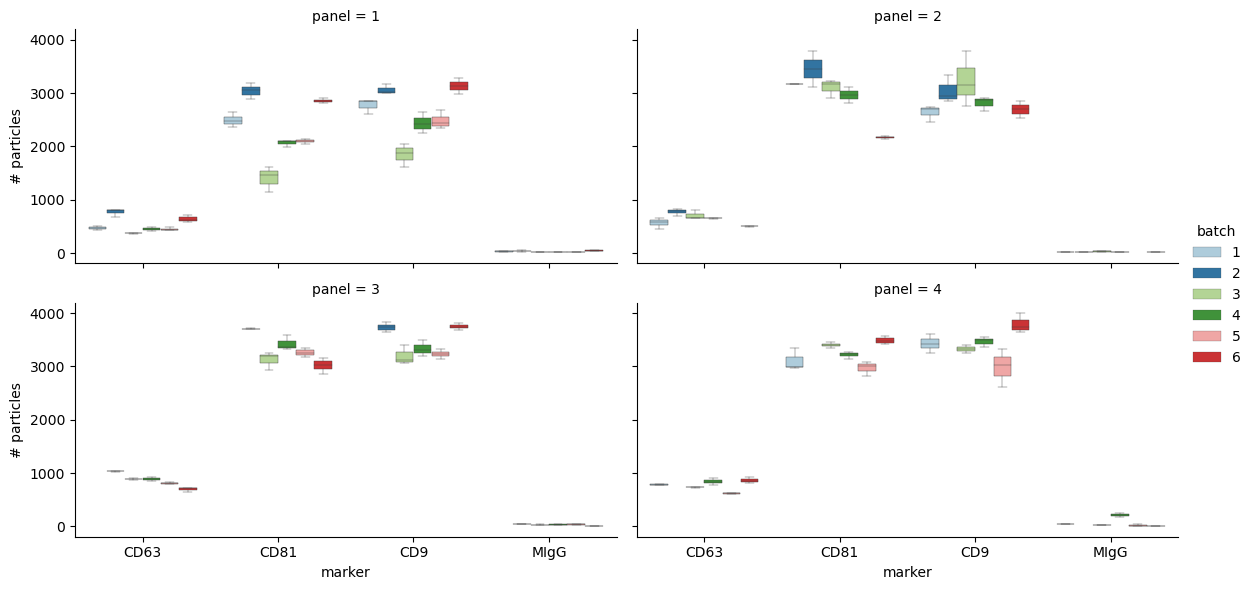

In [32]:
control = df[df.samples == "Pooled Control"]
cont_size = control.groupby(["panel", "batch","marker", "spot"]).size().reset_index()
cont_size.columns = ["panel", "batch","marker", "spot", "# particles"]
#cont_size["batch"] = 
x = "marker"
hue = "batch"
y = "# particles"
col = "panel"
g = sns.catplot(
    data=cont_size, 
    kind="box",
    x=x, y=y, hue=hue,col=col,col_wrap=2,
    palette="Paired",  height=3, aspect=2,
    linewidth=0.3,
    #alpha=.6,
    #sharex=True,
    #sharey=True,
    
)
# ax = sns.boxplot(data=cont_size, x="panel", y="# particles", hue="batch", palette="Paired")
# ax.legend(bbox_to_anchor=(1,1))

In [ ]:
cont_size[(cont_size.panel ==4)& (cont_size.marker == "CD81")].groupby(["batch"])["# particles"].mean()

# Remove Pooled Control

In [91]:

df = df_merge[df_merge.samples !="Pooled Control"]
mapping = {"MCI":"AD", "PD-noMCI":"PDD", "PD-MCI":"PDD", "HC":"HC", "AD":"AD", "PDD":"PDD"}
df["Diagnosis"] = df["Diagnosis"].map(mapping).values
df


/var/folders/yn/qvpxfrdd5870gxhq9hf9jvc40000gq/T/ipykernel_2643/1782400681.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Diagnosis"] = df["Diagnosis"].map(mapping).values


Unnamed: 0    spot  A-Beta  CD47    PrP         IM marker samples   
0                 0   Spot4     0.0   0.0    0.0  50.350120   CD63       9  \
1                 1   Spot4     0.0   0.0  624.0  50.389418   CD63       9   
2                 2   Spot4     0.0   0.0    0.0  50.520433   CD63       9   
3                 3   Spot4     0.0   0.0    0.0  51.116215   CD63       9   
4                 4   Spot4     0.0   0.0  491.0  55.023671   CD63       9   
...             ...     ...     ...   ...    ...        ...    ...     ...   
6394615     1725898  Spot12     NaN   0.0    0.0  56.603524   MIgG      58   
6394616     1725899  Spot12     NaN   0.0    0.0  51.135725   MIgG      58   
6394617     1725900  Spot12     NaN   0.0    0.0  51.770379   MIgG      58   
6394618     1725901  Spot12     NaN   0.0  543.0  51.780516   MIgG      58   
6394619     1725902  Spot12     NaN   0.0    0.0  53.537604   MIgG      58   

         batch  panel  Tau-5  A-Syn  ApoE   TPAD ID Linkcode  Cohort   
0            1      1    NaN    NaN   NaN  TPAD0491   141362  Poston  \
1            1      1    NaN    NaN   NaN  TPAD0491   141362  Poston   
2            1      1    NaN    NaN   NaN  TPAD0491   141362  Poston   
3            1      1    NaN    NaN   NaN  TPAD0491   141362  Poston   
4            1      1    NaN    NaN   NaN  TPAD0491   141362  Poston   
...        ...    ...    ...    ...   ...       ...      ...     ...   
6394615      6      4    NaN    NaN   0.0  TPAD0367     1211    ADRC   
6394616      6      4    NaN    NaN   0.0  TPAD0367     1211    ADRC   
6394617      6      4    NaN    NaN   0.0  TPAD0367     1211    ADRC   
6394618      6      4    NaN    NaN   0.0  TPAD0367     1211    ADRC   
6394619      6      4    NaN    NaN   0.0  TPAD0367     1211    ADRC   

        Diagnosis PID 1-90  
0              HC        9  
1              HC        9  
2              HC        9  
3              HC        9  
4              HC        9  
...           ...      ...  
6394615        AD       58  
6394616        AD       58  
6394617        AD       58  
6394618        AD       58  
6394619        AD       58  

[6046757 rows x 18 columns]

In [92]:
df["Prp+"] = df["PrP"].apply(lambda x : int(x>0)).values
df["Prp/Cd47+"] = np.where(((df["PrP"]>0 ) & (df["CD47"]>0 )), 1, 0)

df 

/var/folders/yn/qvpxfrdd5870gxhq9hf9jvc40000gq/T/ipykernel_2643/4281473347.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Prp+"] = df["PrP"].apply(lambda x : int(x>0)).values
/var/folders/yn/qvpxfrdd5870gxhq9hf9jvc40000gq/T/ipykernel_2643/4281473347.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Prp/Cd47+"] = np.where(((df["PrP"]>0 ) & (df["CD47"]>0 )), 1, 0)


Unnamed: 0    spot  A-Beta  CD47    PrP         IM marker samples   
0                 0   Spot4     0.0   0.0    0.0  50.350120   CD63       9  \
1                 1   Spot4     0.0   0.0  624.0  50.389418   CD63       9   
2                 2   Spot4     0.0   0.0    0.0  50.520433   CD63       9   
3                 3   Spot4     0.0   0.0    0.0  51.116215   CD63       9   
4                 4   Spot4     0.0   0.0  491.0  55.023671   CD63       9   
...             ...     ...     ...   ...    ...        ...    ...     ...   
6394615     1725898  Spot12     NaN   0.0    0.0  56.603524   MIgG      58   
6394616     1725899  Spot12     NaN   0.0    0.0  51.135725   MIgG      58   
6394617     1725900  Spot12     NaN   0.0    0.0  51.770379   MIgG      58   
6394618     1725901  Spot12     NaN   0.0  543.0  51.780516   MIgG      58   
6394619     1725902  Spot12     NaN   0.0    0.0  53.537604   MIgG      58   

         batch  panel  Tau-5  A-Syn  ApoE   TPAD ID Linkcode  Cohort   
0            1      1    NaN    NaN   NaN  TPAD0491   141362  Poston  \
1            1      1    NaN    NaN   NaN  TPAD0491   141362  Poston   
2            1      1    NaN    NaN   NaN  TPAD0491   141362  Poston   
3            1      1    NaN    NaN   NaN  TPAD0491   141362  Poston   
4            1      1    NaN    NaN   NaN  TPAD0491   141362  Poston   
...        ...    ...    ...    ...   ...       ...      ...     ...   
6394615      6      4    NaN    NaN   0.0  TPAD0367     1211    ADRC   
6394616      6      4    NaN    NaN   0.0  TPAD0367     1211    ADRC   
6394617      6      4    NaN    NaN   0.0  TPAD0367     1211    ADRC   
6394618      6      4    NaN    NaN   0.0  TPAD0367     1211    ADRC   
6394619      6      4    NaN    NaN   0.0  TPAD0367     1211    ADRC   

        Diagnosis PID 1-90  Prp+  Prp/Cd47+  
0              HC        9     0          0  
1              HC        9     1          0  
2              HC        9     0          0  
3              HC        9     0          0  
4              HC        9     1          0  
...           ...      ...   ...        ...  
6394615        AD       58     0          0  
6394616        AD       58     0          0  
6394617        AD       58     0          0  
6394618        AD       58     1          0  
6394619        AD       58     0          0  

[6046757 rows x 20 columns]

In [85]:
df

Unnamed: 0    spot  A-Beta  CD47    PrP         IM marker samples   
0                 0   Spot4     0.0   0.0    0.0  50.350120   CD63       9  \
1                 1   Spot4     0.0   0.0  624.0  50.389418   CD63       9   
2                 2   Spot4     0.0   0.0    0.0  50.520433   CD63       9   
3                 3   Spot4     0.0   0.0    0.0  51.116215   CD63       9   
4                 4   Spot4     0.0   0.0  491.0  55.023671   CD63       9   
...             ...     ...     ...   ...    ...        ...    ...     ...   
6394615     1725898  Spot12     NaN   0.0    0.0  56.603524   MIgG      58   
6394616     1725899  Spot12     NaN   0.0    0.0  51.135725   MIgG      58   
6394617     1725900  Spot12     NaN   0.0    0.0  51.770379   MIgG      58   
6394618     1725901  Spot12     NaN   0.0  543.0  51.780516   MIgG      58   
6394619     1725902  Spot12     NaN   0.0    0.0  53.537604   MIgG      58   

         batch  panel  Tau-5  A-Syn  ApoE   TPAD ID Linkcode  Cohort   
0            1      1    NaN    NaN   NaN  TPAD0491   141362  Poston  \
1            1      1    NaN    NaN   NaN  TPAD0491   141362  Poston   
2            1      1    NaN    NaN   NaN  TPAD0491   141362  Poston   
3            1      1    NaN    NaN   NaN  TPAD0491   141362  Poston   
4            1      1    NaN    NaN   NaN  TPAD0491   141362  Poston   
...        ...    ...    ...    ...   ...       ...      ...     ...   
6394615      6      4    NaN    NaN   0.0  TPAD0367     1211    ADRC   
6394616      6      4    NaN    NaN   0.0  TPAD0367     1211    ADRC   
6394617      6      4    NaN    NaN   0.0  TPAD0367     1211    ADRC   
6394618      6      4    NaN    NaN   0.0  TPAD0367     1211    ADRC   
6394619      6      4    NaN    NaN   0.0  TPAD0367     1211    ADRC   

        Diagnosis PID 1-90  Prp+  Prp/Cd47+  
0              HC        9     0          0  
1              HC        9     1          0  
2              HC        9     0          0  
3              HC        9     0          0  
4              HC        9     1          0  
...           ...      ...   ...        ...  
6394615        AD       58     0          0  
6394616        AD       58     0          0  
6394617        AD       58     0          0  
6394618        AD       58     1          0  
6394619        AD       58     0          0  

[6046757 rows x 20 columns]

CD63
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

PrP+_HC vs. PrP+_PDD: Mann-Whitney-Wilcoxon test two-sided, P_val:1.708e-06 U_stat=3.097e+04
PrP+_AD vs. PrP+_HC: Mann-Whitney-Wilcoxon test two-sided, P_val:4.346e-01 U_stat=4.046e+04
PrP-_AD vs. PrP-_HC: Mann-Whitney-Wilcoxon test two-sided, P_val:9.264e-01 U_stat=4.223e+04
PrP-_HC vs. PrP-_PDD: Mann-Whitney-Wilcoxon test two-sided, P_val:2.137e-04 U_stat=3.309e+04
PrP+_AD vs. PrP+_PDD: Mann-Whitney-Wilcoxon test two-sided, P_val:1.289e-07 U_stat=3.091e+04
PrP-_AD vs. PrP-_PDD: Mann-Whitney-Wilcoxon test two-sided, P_val:8.893e-04 U_stat=3.482e+04
CD81
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

PrP+_HC vs. PrP+_PDD: Mann-Whitney-Wilcoxon test two-sided, P_val:4.431e

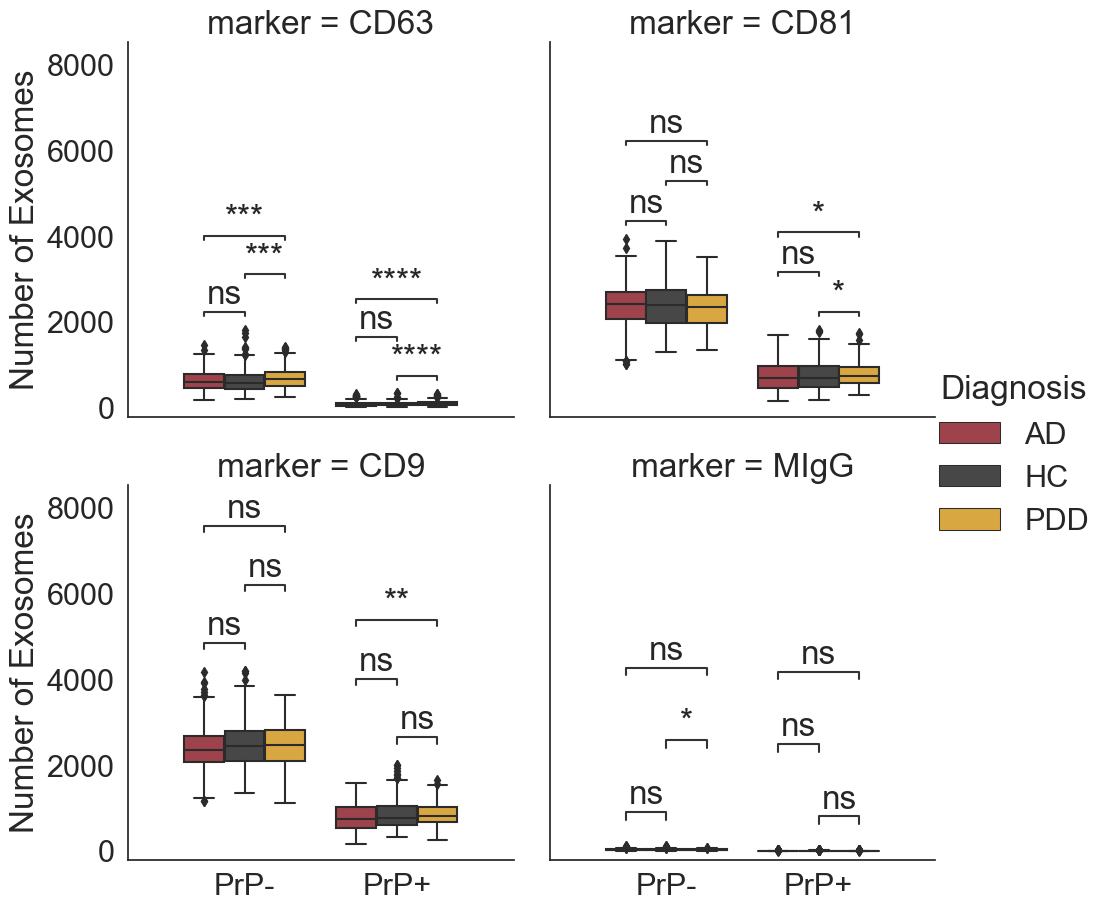

In [103]:
groupby_cols = ['panel', "Diagnosis", 'samples', "marker", "spot"]
var_in = "Prp+"
y="Number of Exosomes"
to_plot = pd.DataFrame(df.groupby(groupby_cols + [var_in])[var_in].count()) #, columns = )#.reset_index()
to_plot.columns = [y]
to_plot.reset_index(inplace=True)
to_plot["Prp+"] = to_plot["Prp+"].map({0:"PrP-", 1:"PrP+"}).values
#to_plot[var_in] = to_plot[var_in].map({0:"PrP/CD47-", 1:"PrP/CD47+"}).values

to_plot

palette_diagnosis = {"AD":"#AD343E", "HC":"#474747", "PDD":"#F2AF29"}
x = "Prp+"

hue="Diagnosis"
col="marker"
sns.set(style="white", font_scale=2)
g = sns.catplot(data = to_plot, hue=hue, y=y, x =x, kind="box", col=col, palette=palette_diagnosis, col_wrap=2)
pairs = [
        (("PrP+","AD"), ("PrP+","HC")),
         (("PrP+","HC"), ("PrP+","PDD")), 
         (("PrP+","AD"), ("PrP+","PDD")),
    (("PrP-","AD"), ("PrP-","HC")),
         (("PrP-","HC"), ("PrP-","PDD")), 
         (("PrP-","AD"), ("PrP-","PDD"))
        ]

for name,ax in g.axes_dict.items():
# if True:
#         ax = g.ax
        print(name)
# # subset the table otherwise the stats were calculated on the whole dataset
        tmp = to_plot[to_plot[col]==name]
        annot = Annotator(ax, pairs, data=tmp, x=x, y=y, hue=hue) 
        annot.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
        annot.apply_test().annotate()
        ax.set_xlabel("")
#to_plot = to_plot.reset_index()
#to_plot

CD63
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

PrP/CD47+_HC vs. PrP/CD47+_PDD: Mann-Whitney-Wilcoxon test two-sided, P_val:8.601e-01 U_stat=2.797e+04
PrP/CD47-_AD vs. PrP/CD47-_HC: Mann-Whitney-Wilcoxon test two-sided, P_val:5.287e-01 U_stat=4.077e+04
PrP/CD47-_HC vs. PrP/CD47-_PDD: Mann-Whitney-Wilcoxon test two-sided, P_val:6.826e-07 U_stat=3.061e+04
PrP/CD47+_AD vs. PrP/CD47+_HC: Mann-Whitney-Wilcoxon test two-sided, P_val:5.432e-02 U_stat=2.441e+04
PrP/CD47+_AD vs. PrP/CD47+_PDD: Mann-Whitney-Wilcoxon test two-sided, P_val:6.875e-02 U_stat=2.361e+04
PrP/CD47-_AD vs. PrP/CD47-_PDD: Mann-Whitney-Wilcoxon test two-sided, P_val:1.347e-07 U_stat=3.093e+04
CD81
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

PrP/CD47+_HC

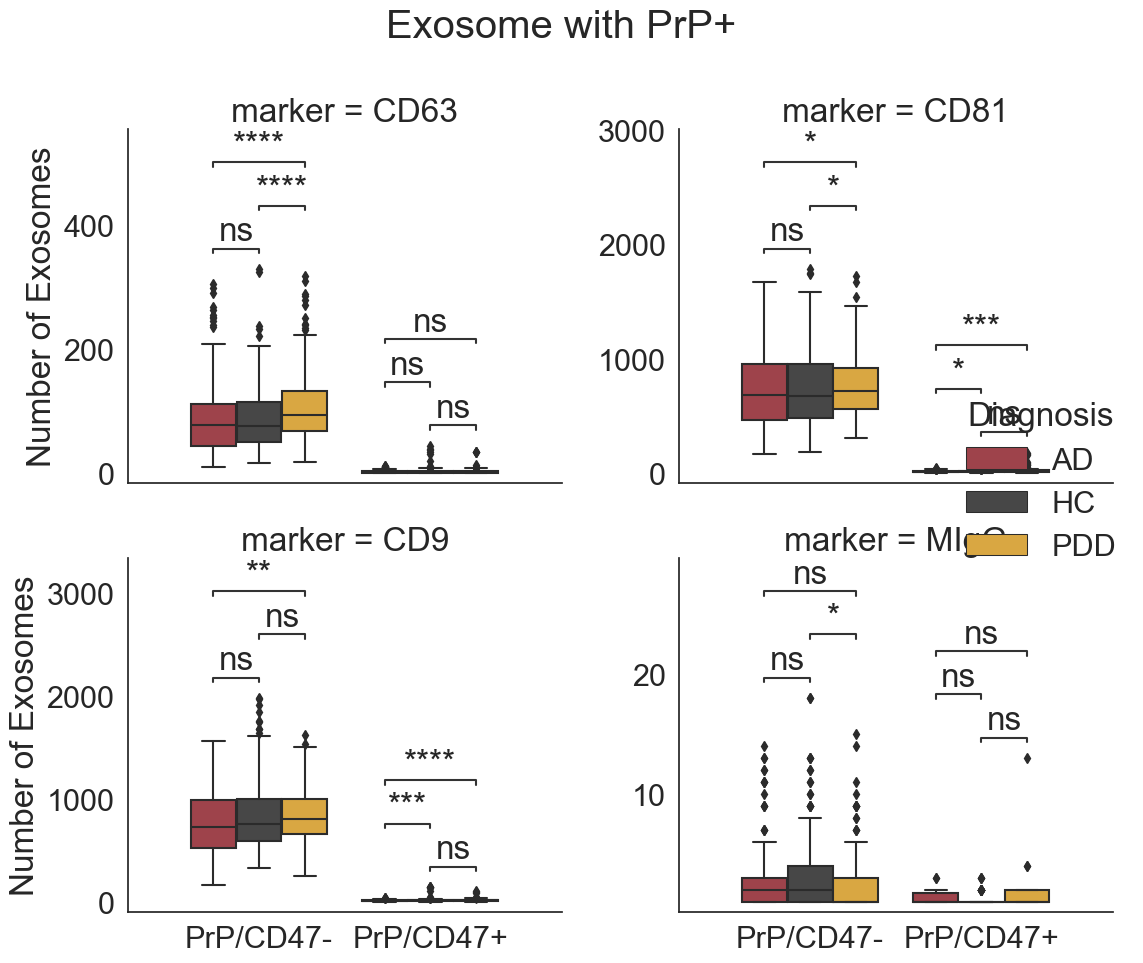

In [124]:
groupby_cols = ['panel', "Diagnosis", 'samples', "marker", "spot"]
var_in = "Prp/Cd47+"
x1 = "PrP/CD47-"
x2="PrP/CD47+"
y = "Number of Exosomes"
to_plot = pd.DataFrame(df[df["Prp+"]==1].groupby(groupby_cols + [var_in])[var_in].count()) #, columns = )#.reset_index()
to_plot.columns = [y]
to_plot.reset_index(inplace=True)
#to_plot["Prp+"] = to_plot["Prp+"].map({0:"PrP-", 1:"PrP+"}).values
to_plot[var_in] = to_plot[var_in].map({0:x1, 1:x2}).values

to_plot

palette_diagnosis = {"AD":"#AD343E", "HC":"#474747", "PDD":"#F2AF29"}
x = var_in

hue="Diagnosis"
col="marker"

sns.set(style="white", font_scale=2)
g = sns.catplot(data = to_plot, hue=hue, y=y, x =x, kind="box", col=col, palette=palette_diagnosis, col_wrap=2, sharey=False)
pairs = [
        ((x1,"AD"), (x1,"HC")),
         ((x1,"HC"), (x1,"PDD")), 
         ((x1,"AD"), (x1,"PDD")),
    ((x2,"AD"), (x2,"HC")),
         ((x2,"HC"), (x2,"PDD")), 
         ((x2,"AD"), (x2,"PDD"))
        ]

for name,ax in g.axes_dict.items():
# if True:
#         ax = g.ax
        print(name)
# # subset the table otherwise the stats were calculated on the whole dataset
        tmp = to_plot[to_plot[col]==name]
        annot = Annotator(ax, pairs, data=tmp, x=x, y=y, hue=hue) 
        annot.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
        annot.apply_test().annotate()
        ax.set_xlabel("")
#plt.legend(bbox_to_anchor=(1.1,1))
plt.suptitle("Exosome with PrP+")
plt.tight_layout()
#to_plot = to_plot.reset_index()
#to_plot

/var/folders/yn/qvpxfrdd5870gxhq9hf9jvc40000gq/T/ipykernel_2643/4001353654.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Diagnosis"] = df["Diagnosis"].map(mapping).values


In [125]:
df

Unnamed: 0    spot  A-Beta  CD47    PrP         IM marker samples   
0                 0   Spot4     0.0   0.0    0.0  50.350120   CD63       9  \
1                 1   Spot4     0.0   0.0  624.0  50.389418   CD63       9   
2                 2   Spot4     0.0   0.0    0.0  50.520433   CD63       9   
3                 3   Spot4     0.0   0.0    0.0  51.116215   CD63       9   
4                 4   Spot4     0.0   0.0  491.0  55.023671   CD63       9   
...             ...     ...     ...   ...    ...        ...    ...     ...   
6394615     1725898  Spot12     NaN   0.0    0.0  56.603524   MIgG      58   
6394616     1725899  Spot12     NaN   0.0    0.0  51.135725   MIgG      58   
6394617     1725900  Spot12     NaN   0.0    0.0  51.770379   MIgG      58   
6394618     1725901  Spot12     NaN   0.0  543.0  51.780516   MIgG      58   
6394619     1725902  Spot12     NaN   0.0    0.0  53.537604   MIgG      58   

         batch  panel  Tau-5  A-Syn  ApoE   TPAD ID Linkcode  Cohort   
0            1      1    NaN    NaN   NaN  TPAD0491   141362  Poston  \
1            1      1    NaN    NaN   NaN  TPAD0491   141362  Poston   
2            1      1    NaN    NaN   NaN  TPAD0491   141362  Poston   
3            1      1    NaN    NaN   NaN  TPAD0491   141362  Poston   
4            1      1    NaN    NaN   NaN  TPAD0491   141362  Poston   
...        ...    ...    ...    ...   ...       ...      ...     ...   
6394615      6      4    NaN    NaN   0.0  TPAD0367     1211    ADRC   
6394616      6      4    NaN    NaN   0.0  TPAD0367     1211    ADRC   
6394617      6      4    NaN    NaN   0.0  TPAD0367     1211    ADRC   
6394618      6      4    NaN    NaN   0.0  TPAD0367     1211    ADRC   
6394619      6      4    NaN    NaN   0.0  TPAD0367     1211    ADRC   

        Diagnosis PID 1-90  Prp+  Prp/Cd47+  
0              HC        9     0          0  
1              HC        9     1          0  
2              HC        9     0          0  
3              HC        9     0          0  
4              HC        9     1          0  
...           ...      ...   ...        ...  
6394615        AD       58     0          0  
6394616        AD       58     0          0  
6394617        AD       58     0          0  
6394618        AD       58     1          0  
6394619        AD       58     0          0  

[6046757 rows x 20 columns]

In [14]:
# distribution plots by batch and by groups
marker = ['A-Beta', 'CD47', 'PrP', "Tau-5", "ApoE", "A-Syn", ]
groupby_cols = ['panel', 'samples', "marker", "spot"]
df_plt = (df.groupby(groupby_cols)[marker].apply(lambda x: (x>0).sum())/df.groupby(groupby_cols).count().loc[:, marker]*100).reset_index()
df_plt = df_plt.melt(groupby_cols)
df_plt.head(3)

panel samples marker   spot variable     value
0      1       1   CD63  Spot4   A-Beta  2.133713
1      1       1   CD63  Spot5   A-Beta  1.032448
2      1       1   CD63  Spot6   A-Beta  1.312336

/Users/eloiseberson/anaconda3/envs/R_py/lib/python3.8/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  resampler = integers(0, n_units, n_units, dtype=np.intp)
/Users/eloiseberson/anaconda3/envs/R_py/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1560: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/Users/eloiseberson/anaconda3/envs/R_py/lib/python3.8/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  resampler = integers(0, n_units, n_units, dtype=np.intp)
/Users/eloiseberson/anaconda3/envs/R_py/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1560: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/Users/eloiseberson/anaconda3/envs/R_py/lib/python3.8/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  resampler = integers(0, n_units, n_units, dtype=np.intp)
/Users/eloiseberson/anaconda3/envs/R_py/lib/python3.8/site-packages/numpy/lib/n

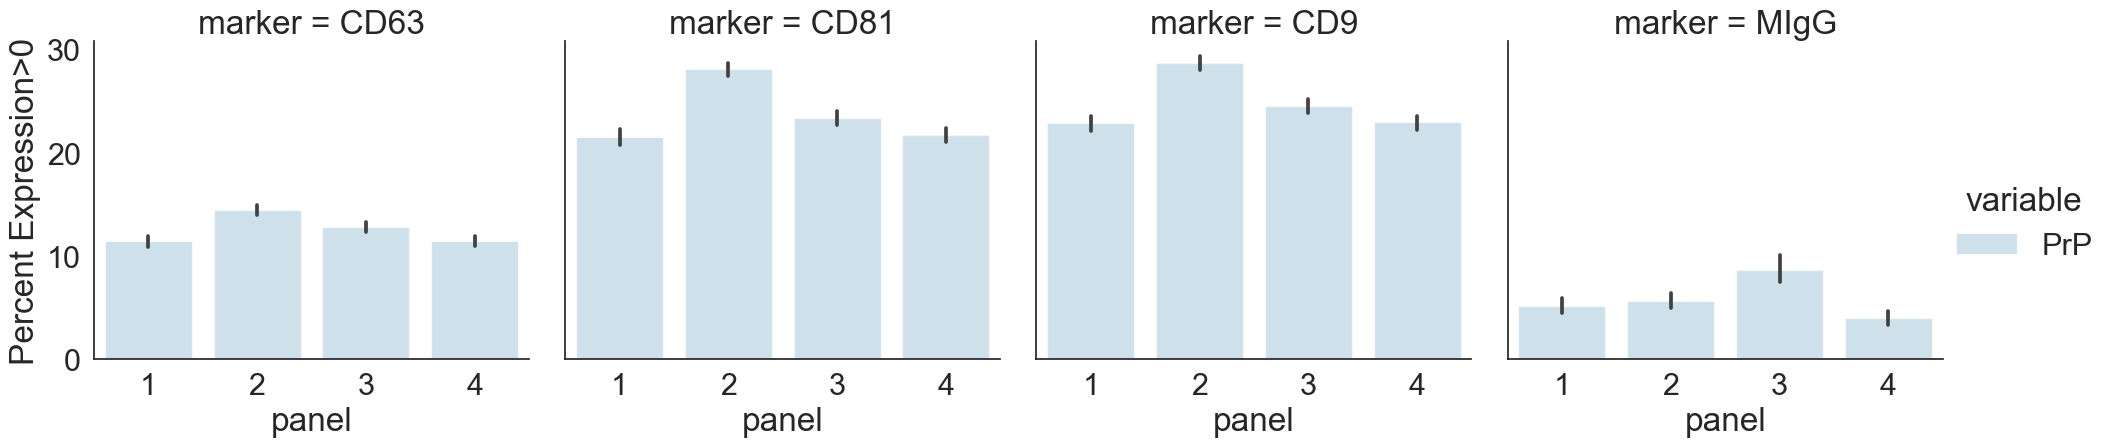

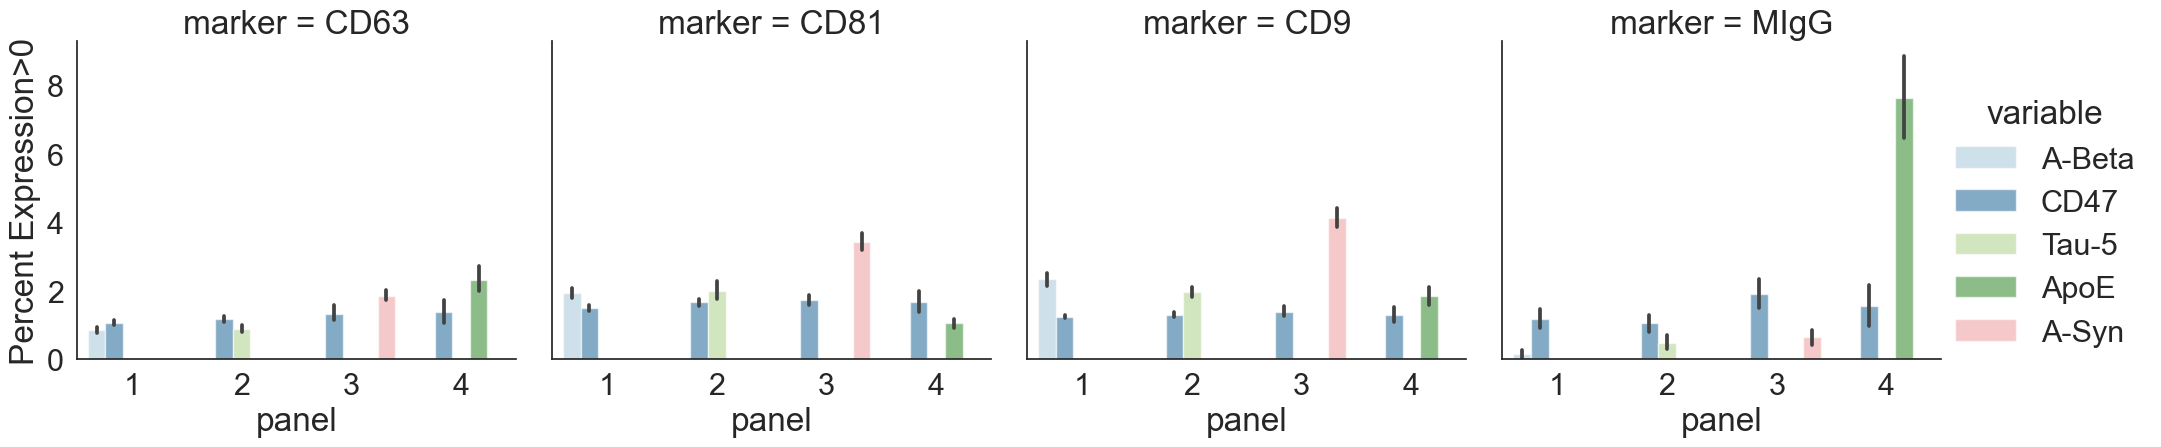

In [76]:
x="panel"
sns.set(font_scale=2, style="white")
y="Percent Expression>0"
df_plt.rename({"value":y}, axis=1, inplace=True)
g = sns.catplot(
    data=df_plt.loc[df_plt.variable=='PrP', :], 
    kind="bar",
    x=x, y=y, hue="variable",col="marker",#col_wrap=2,
    palette="Paired", alpha=.6, height=5, aspect=1,
    #sharex=True,
    sharey=True,
    
)
g = sns.catplot(
    data=df_plt.loc[df_plt.variable!='PrP', :], 
    kind="bar",
    x=x, y=y, hue="variable",col="marker",#col_wrap=2,
    palette="Paired", alpha=.6, height=5, aspect=1,
    #sharex=True,
    sharey=True,
    
)
# g.despine(left=True)
# g.set_axis_labels(x, "Percent Expression>0")

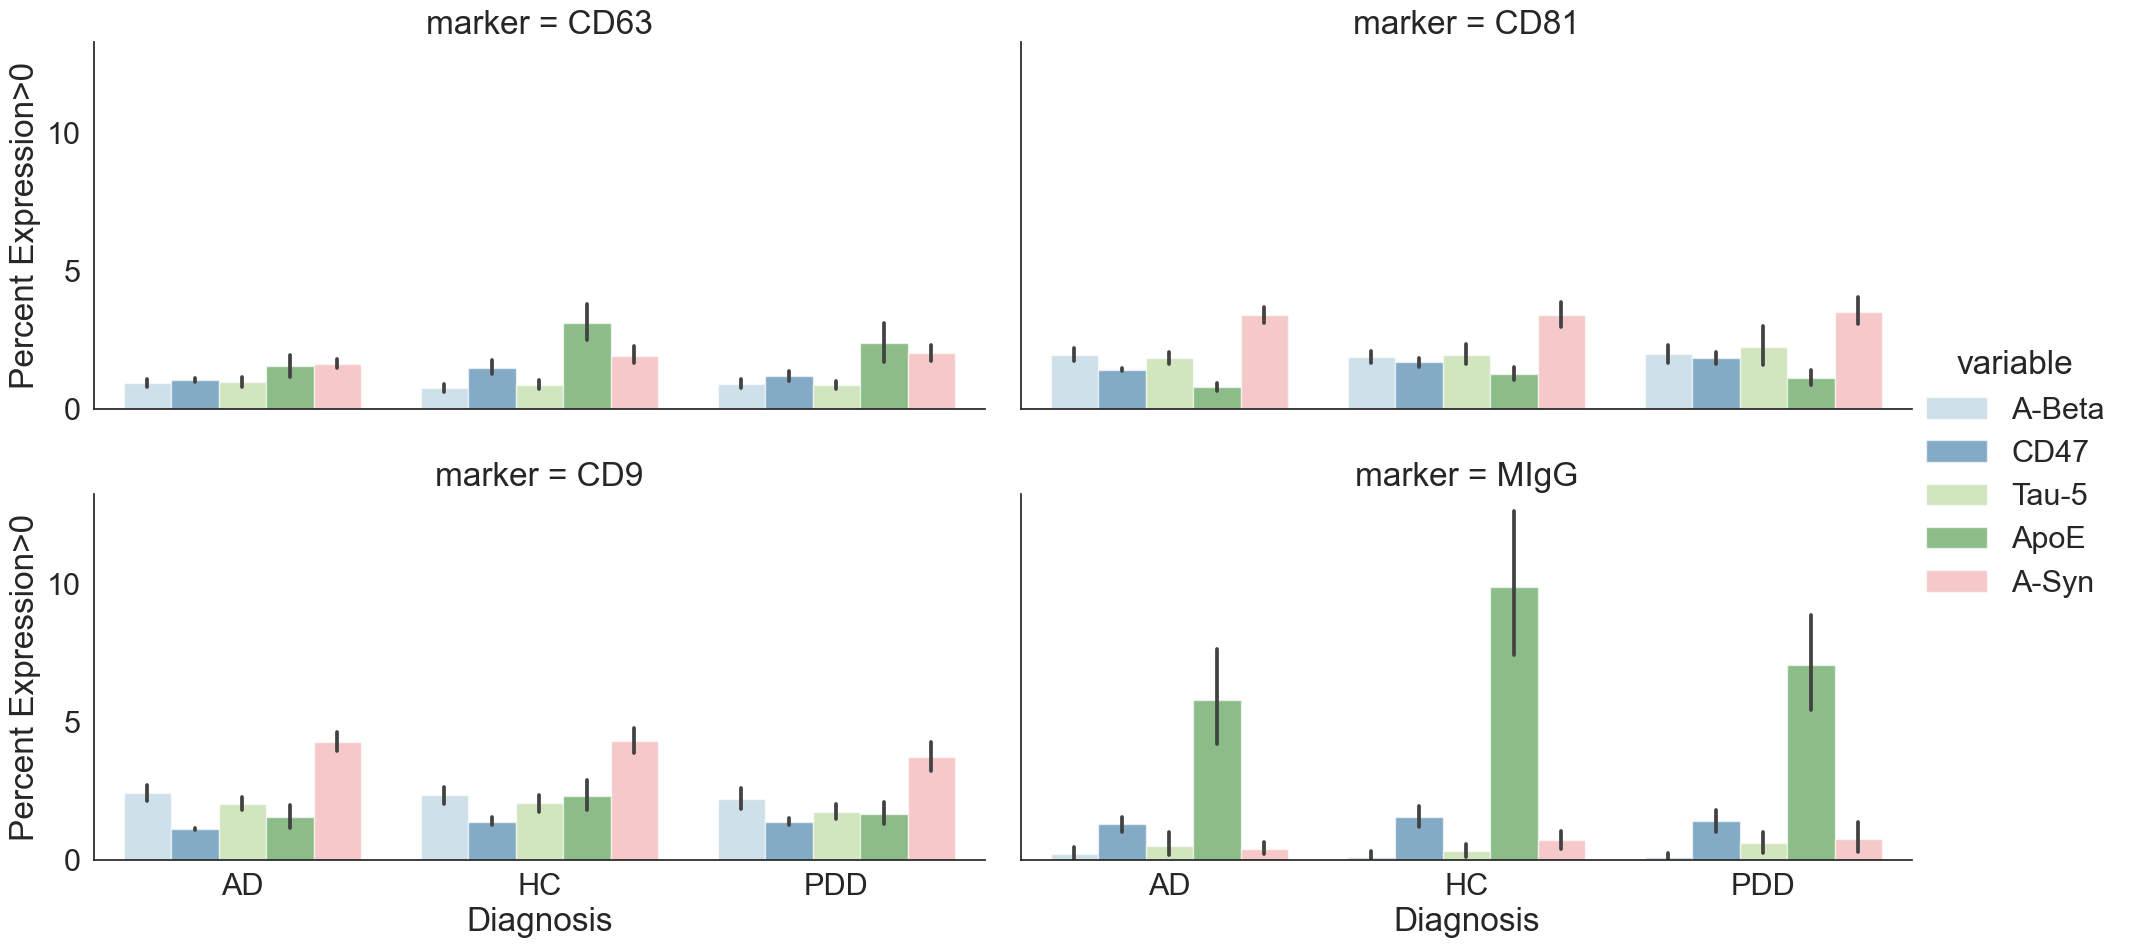

In [81]:
groupby_cols = ['Diagnosis', "panel", 'samples', "marker", "spot"]
df_plt = (df.groupby(groupby_cols)[marker].apply(lambda x: (x>0).sum())/df.groupby(groupby_cols).count().loc[:, marker]*100).reset_index()
df_plt = df_plt.melt(groupby_cols)
df_plt.head(3)
x="Diagnosis"
sns.set(font_scale=2, style="white")
y="Percent Expression>0"
df_plt.rename({"value":y}, axis=1, inplace=True)
# g = sns.catplot(
#     data=df_plt.loc[df_plt.variable=='PrP', :], 
#     kind="bar",
#     x=x, y=y, hue="variable",col="marker",#col_wrap=2,
#     palette="Paired", alpha=.6, height=5, aspect=1.5,
#     #sharex=True,
#     sharey=True,
    
# )
g = sns.catplot(
    data=df_plt.loc[df_plt.variable!='PrP', :], 
    kind="bar",
    x=x, y=y, hue="variable",col="marker",col_wrap=2,
    palette="Paired", alpha=.6, height=5, aspect=2,
    #sharex=True,
    sharey=True,
    
)

In [113]:
groupby_cols = ['Diagnosis', "panel", 'samples', "marker", "spot"]
df_plt = df.groupby(groupby_cols).size().reset_index()
df_plt = df_plt.melt(groupby_cols)
df_plt.rename({"value":"Number of Exosome"},axis=1, inplace=True)

CD63
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

AD vs. HC: Mann-Whitney-Wilcoxon test two-sided, P_val:9.958e-01 U_stat=4.203e+04
HC vs. PDD: Mann-Whitney-Wilcoxon test two-sided, P_val:3.986e-05 U_stat=3.229e+04
AD vs. PDD: Mann-Whitney-Wilcoxon test two-sided, P_val:1.794e-04 U_stat=3.397e+04
CD81
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

AD vs. HC: Mann-Whitney-Wilcoxon test two-sided, P_val:9.257e-01 U_stat=4.475e+04
HC vs. PDD: Mann-Whitney-Wilcoxon test two-sided, P_val:9.663e-01 U_stat=4.269e+04
AD vs. PDD: Mann-Whitney-Wilcoxon test two-sided, P_val:7.100e-01 U_stat=4.322e+04
CD9
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     **

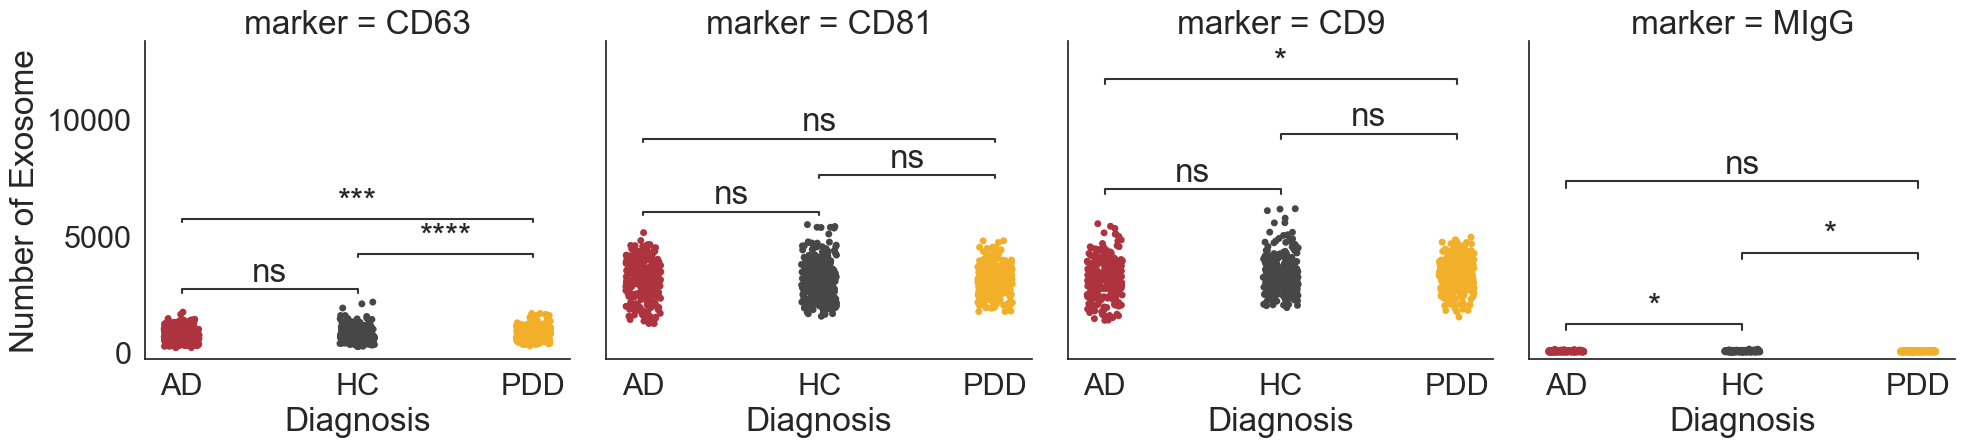

In [123]:
x="Diagnosis"
y="Number of Exosome"
col="marker"
g = sns.catplot(data=df_plt, x=x, y=y, palette=palette_diagnosis, col=col)
pairs = [("AD", "HC"), ("HC", "PDD"), ("AD", "PDD")]
for name,ax in g.axes_dict.items():
# if True:
#         ax = g.ax
        print(name)
# # subset the table otherwise the stats were calculated on the whole dataset
        tmp = df_plt[df_plt[col]==name]
        annot = Annotator(ax, pairs, data=tmp, x=x, y=y, ) 
        annot.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
        annot.apply_test().annotate()
        #ax.set_xlabel("")

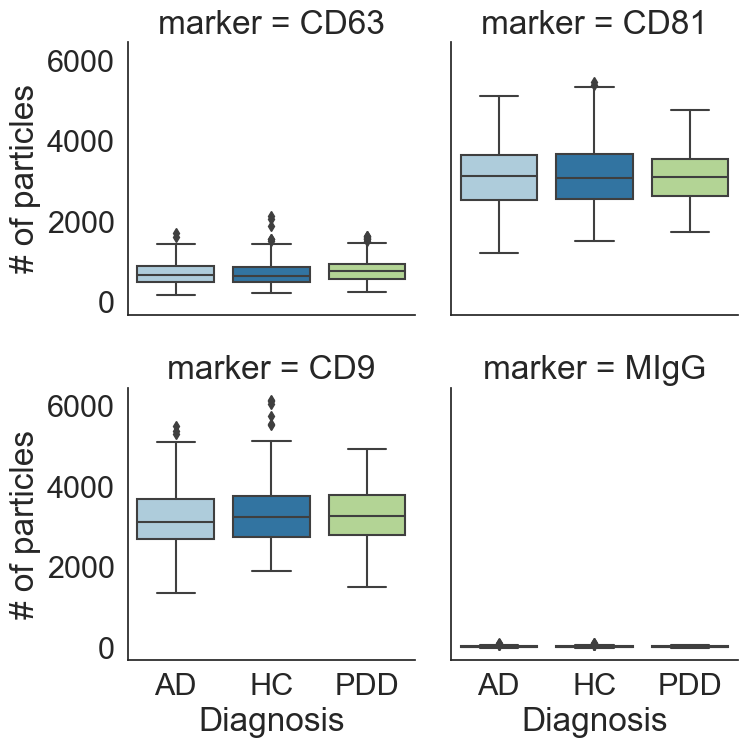

In [96]:
# groupby_cols = ['Diagnosis', "panel", 'samples', "marker", "spot"]
# df_plt = df.groupby(groupby_cols).size().reset_index()
# df_plt = df_plt.melt(groupby_cols)
# df_plt.head(3)
# x="Diagnosis"
# sns.set(font_scale=2, style="white")
# y="# of particles"
# df_plt.rename({"value":y}, axis=1, inplace=True)
# # g = sns.catplot(
# #     data=df_plt.loc[df_plt.variable=='PrP', :], 
# #     kind="bar",
# #     x=x, y=y, hue="variable",col="marker",#col_wrap=2,
# #     palette="Paired", alpha=.6, height=5, aspect=1.5,
# #     #sharex=True,
# #     sharey=True,
    
# # )
# g = sns.catplot(
#     data=df_plt.loc[df_plt.variable!='PrP', :], 
#     kind="box",
#     x=x, y=y,col="marker",col_wrap=2,
#     palette="Paired", #alpha=.6, 
#     height=4, aspect=1,
#     #sharex=True,
#     #sharey=True,
    
)

In [ ]:
# mark = "CD81"
# var="Tau-5"
# df_ = df_plt[(df_plt.marker==mark) & (df_plt.variable==var)]
# x="Diagnosis"
# sns.set(font_scale=2, style="white")
# y="Percent Expression>0"
# g = sns.catplot(
#     data=df_, 
#     kind="bar",
#     x=x, y=y, hue="variable",#col="panel",#col_wrap=2,
#     palette="Paired", alpha=.6, height=5, aspect=2,
#     #sharex=True,
#     sharey=True,
    
# )

# pairs = [("PD-MCI", i) for i in df_plt.Diagnosis.unique()]

# #for name,ax in g.axes_dict.items():
# if True:
#         ax = g.ax
# # subset the table otherwise the stats were calculated on the whole dataset
#         annot = Annotator(ax, pairs, data=df_, x=x, y=y) 
#         annot.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
#         annot.apply_test().annotate()
# g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
# g.fig.suptitle(mark +' / '+ var)

In [107]:
# #from sklearn.neighbors import KNeighborsClassifier
# from sklearn.cluster import KMeans
# n_panel = 2
# n_clusters = 4 + n_panel*4
# kmeans = KMeans(
#         init="random",
#         n_clusters=n_clusters,
#         n_init=10,
#         max_iter=300,
#         random_state=42
#            )
# cols = ['A-Beta', 'CD47', 'PrP', "Tau-5", "IM"]
# kmeans.fit(df[cols].fillna(0))
# clusters = kmeans.labels_
# df["label"] = clusters

In [130]:
df

Unnamed: 0    spot  A-Beta  CD47    PrP         IM marker samples   
0                 0   Spot4     0.0   0.0    0.0  50.350120   CD63       9  \
1                 1   Spot4     0.0   0.0  624.0  50.389418   CD63       9   
2                 2   Spot4     0.0   0.0    0.0  50.520433   CD63       9   
3                 3   Spot4     0.0   0.0    0.0  51.116215   CD63       9   
4                 4   Spot4     0.0   0.0  491.0  55.023671   CD63       9   
...             ...     ...     ...   ...    ...        ...    ...     ...   
6394615     1725898  Spot12     NaN   0.0    0.0  56.603524   MIgG      58   
6394616     1725899  Spot12     NaN   0.0    0.0  51.135725   MIgG      58   
6394617     1725900  Spot12     NaN   0.0    0.0  51.770379   MIgG      58   
6394618     1725901  Spot12     NaN   0.0  543.0  51.780516   MIgG      58   
6394619     1725902  Spot12     NaN   0.0    0.0  53.537604   MIgG      58   

         batch  panel  Tau-5  A-Syn  ApoE   TPAD ID Linkcode  Cohort   
0            1      1    NaN    NaN   NaN  TPAD0491   141362  Poston  \
1            1      1    NaN    NaN   NaN  TPAD0491   141362  Poston   
2            1      1    NaN    NaN   NaN  TPAD0491   141362  Poston   
3            1      1    NaN    NaN   NaN  TPAD0491   141362  Poston   
4            1      1    NaN    NaN   NaN  TPAD0491   141362  Poston   
...        ...    ...    ...    ...   ...       ...      ...     ...   
6394615      6      4    NaN    NaN   0.0  TPAD0367     1211    ADRC   
6394616      6      4    NaN    NaN   0.0  TPAD0367     1211    ADRC   
6394617      6      4    NaN    NaN   0.0  TPAD0367     1211    ADRC   
6394618      6      4    NaN    NaN   0.0  TPAD0367     1211    ADRC   
6394619      6      4    NaN    NaN   0.0  TPAD0367     1211    ADRC   

        Diagnosis PID 1-90  
0              HC        9  
1              HC        9  
2              HC        9  
3              HC        9  
4              HC        9  
...           ...      ...  
6394615        AD       58  
6394616        AD       58  
6394617        AD       58  
6394618        AD       58  
6394619        AD       58  

[6046757 rows x 18 columns]

In [613]:
#handmade combinations
import itertools
import numpy as np
cols = [ "IM",'PrP', 'CD47','A-Beta', "Tau-5", "ApoE", "A-Syn",]
comb_ = []
for L in range(len(cols) + 1):
    for subset in itertools.combinations(cols, L):
        comb_.append(subset)
coloc = []
# df_def = pd.DataFrame(columns=["cluster"] +cols)
null = []
df[cols] = df[cols].astype(float)
df_ = df.fillna(0).loc[df[cols].sum(1)>0,:]
df_.reset_index(inplace=True, drop=True)


non_overlapping = True
for mm in comb_:
    print(mm)
    if len(mm)>0:
        zero_mar = [it for it in cols if it not in mm]
        pos = [it for it in mm]

        if len(zero_mar)>0:
            if non_overlapping:
                index1 = np.where((df_[zero_mar]==0).all(axis=1))[0]
                index2 =  np.where((df_[pos]>0).all(axis=1))[0]
                index = np.intersect1d(index1,index2)
            else:
                index =  np.where((df_[pos]>0).all(axis=1))[0]

            #index = [it for it in index1 if it in index2]
        else:
            index = np.where((df_[pos]>0).all(axis=1))[0]

        tmp = df_.iloc[index,:].copy()
        
        #if len(tmp)>0:
        tmp["cluster"] = "/".join(pos) + "+"
        coloc.append(tmp)
        if len(tmp) ==0:
            null.append("/".join(pos) + "+")

/var/folders/yn/qvpxfrdd5870gxhq9hf9jvc40000gq/T/ipykernel_2643/1326940689.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[cols] = df[cols].astype(float)


()
('IM',)
('PrP',)
('CD47',)
('A-Beta',)
('Tau-5',)
('ApoE',)
('A-Syn',)
('IM', 'PrP')
('IM', 'CD47')
('IM', 'A-Beta')
('IM', 'Tau-5')
('IM', 'ApoE')
('IM', 'A-Syn')
('PrP', 'CD47')
('PrP', 'A-Beta')
('PrP', 'Tau-5')
('PrP', 'ApoE')
('PrP', 'A-Syn')
('CD47', 'A-Beta')
('CD47', 'Tau-5')
('CD47', 'ApoE')
('CD47', 'A-Syn')
('A-Beta', 'Tau-5')
('A-Beta', 'ApoE')
('A-Beta', 'A-Syn')
('Tau-5', 'ApoE')
('Tau-5', 'A-Syn')
('ApoE', 'A-Syn')
('IM', 'PrP', 'CD47')
('IM', 'PrP', 'A-Beta')
('IM', 'PrP', 'Tau-5')
('IM', 'PrP', 'ApoE')
('IM', 'PrP', 'A-Syn')
('IM', 'CD47', 'A-Beta')
('IM', 'CD47', 'Tau-5')
('IM', 'CD47', 'ApoE')
('IM', 'CD47', 'A-Syn')
('IM', 'A-Beta', 'Tau-5')
('IM', 'A-Beta', 'ApoE')
('IM', 'A-Beta', 'A-Syn')
('IM', 'Tau-5', 'ApoE')
('IM', 'Tau-5', 'A-Syn')
('IM', 'ApoE', 'A-Syn')
('PrP', 'CD47', 'A-Beta')
('PrP', 'CD47', 'Tau-5')
('PrP', 'CD47', 'ApoE')
('PrP', 'CD47', 'A-Syn')
('PrP', 'A-Beta', 'Tau-5')
('PrP', 'A-Beta', 'ApoE')
('PrP', 'A-Beta', 'A-Syn')
('PrP', 'Tau-5', 'ApoE'

In [614]:
ratio_def = len(df_)/len(df)
ratio_def

1.0

In [615]:
null

['PrP+',
 'CD47+',
 'A-Beta+',
 'Tau-5+',
 'ApoE+',
 'A-Syn+',
 'PrP/CD47+',
 'PrP/A-Beta+',
 'PrP/Tau-5+',
 'PrP/ApoE+',
 'PrP/A-Syn+',
 'CD47/A-Beta+',
 'CD47/Tau-5+',
 'CD47/ApoE+',
 'CD47/A-Syn+',
 'A-Beta/Tau-5+',
 'A-Beta/ApoE+',
 'A-Beta/A-Syn+',
 'Tau-5/ApoE+',
 'Tau-5/A-Syn+',
 'ApoE/A-Syn+',
 'IM/A-Beta/Tau-5+',
 'IM/A-Beta/ApoE+',
 'IM/A-Beta/A-Syn+',
 'IM/Tau-5/ApoE+',
 'IM/Tau-5/A-Syn+',
 'IM/ApoE/A-Syn+',
 'PrP/CD47/A-Beta+',
 'PrP/CD47/Tau-5+',
 'PrP/CD47/ApoE+',
 'PrP/CD47/A-Syn+',
 'PrP/A-Beta/Tau-5+',
 'PrP/A-Beta/ApoE+',
 'PrP/A-Beta/A-Syn+',
 'PrP/Tau-5/ApoE+',
 'PrP/Tau-5/A-Syn+',
 'PrP/ApoE/A-Syn+',
 'CD47/A-Beta/Tau-5+',
 'CD47/A-Beta/ApoE+',
 'CD47/A-Beta/A-Syn+',
 'CD47/Tau-5/ApoE+',
 'CD47/Tau-5/A-Syn+',
 'CD47/ApoE/A-Syn+',
 'A-Beta/Tau-5/ApoE+',
 'A-Beta/Tau-5/A-Syn+',
 'A-Beta/ApoE/A-Syn+',
 'Tau-5/ApoE/A-Syn+',
 'IM/PrP/A-Beta/Tau-5+',
 'IM/PrP/A-Beta/ApoE+',
 'IM/PrP/A-Beta/A-Syn+',
 'IM/PrP/Tau-5/ApoE+',
 'IM/PrP/Tau-5/A-Syn+',
 'IM/PrP/ApoE/A-Syn+',
 'I

In [616]:
coloc_df = pd.concat(coloc)
coloc_df

Unnamed: 0   spot  A-Beta   CD47    PrP         IM marker samples   
0                 0  Spot4     0.0    0.0    0.0  50.350120   CD63       9  \
2                 2  Spot4     0.0    0.0    0.0  50.520433   CD63       9   
3                 3  Spot4     0.0    0.0    0.0  51.116215   CD63       9   
5                 5  Spot4     0.0    0.0    0.0  58.645589   CD63       9   
6                 6  Spot4     0.0    0.0    0.0  60.627688   CD63       9   
...             ...    ...     ...    ...    ...        ...    ...     ...   
4382300     1673711  Spot3     0.0  318.0  466.0  51.233810   CD81      66   
4382917     1674328  Spot3     0.0  318.0  530.0  60.900835   CD81      66   
4382921     1674332  Spot3     0.0  250.0  774.0  78.601611   CD81      66   
4389834     1681245  Spot8     0.0  295.0  446.0  56.777675    CD9      66   
4391493     1682904  Spot8     0.0  831.0  491.0  57.120720    CD9      66   

         batch  panel  ...  A-Syn  ApoE   TPAD ID Linkcode  Cohort Diagnosis   
0            1      1  ...    0.0   0.0  TPAD0491   141362  Poston        HC  \
2            1      1  ...    0.0   0.0  TPAD0491   141362  Poston        HC   
3            1      1  ...    0.0   0.0  TPAD0491   141362  Poston        HC   
5            1      1  ...    0.0   0.0  TPAD0491   141362  Poston        HC   
6            1      1  ...    0.0   0.0  TPAD0491   141362  Poston        HC   
...        ...    ...  ...    ...   ...       ...      ...     ...       ...   
4382300      6      3  ...  324.0   0.0  TPAD0445   141070  Poston       PDD   
4382917      6      3  ...  323.0   0.0  TPAD0445   141070  Poston       PDD   
4382921      6      3  ...  398.0   0.0  TPAD0445   141070  Poston       PDD   
4389834      6      3  ...  470.0   0.0  TPAD0445   141070  Poston       PDD   
4391493      6      3  ...  355.0   0.0  TPAD0445   141070  Poston       PDD   

        PID 1-90 Prp+  Prp/Cd47+             cluster  
0              9    0          0                 IM+  
2              9    0          0                 IM+  
3              9    0          0                 IM+  
5              9    0          0                 IM+  
6              9    0          0                 IM+  
...          ...  ...        ...                 ...  
4382300       66    1          1  IM/PrP/CD47/A-Syn+  
4382917       66    1          1  IM/PrP/CD47/A-Syn+  
4382921       66    1          1  IM/PrP/CD47/A-Syn+  
4389834       66    1          1  IM/PrP/CD47/A-Syn+  
4391493       66    1          1  IM/PrP/CD47/A-Syn+  

[6046757 rows x 21 columns]

/var/folders/yn/qvpxfrdd5870gxhq9hf9jvc40000gq/T/ipykernel_2643/1506386790.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar_ax.set_yticklabels(['0', '1'])


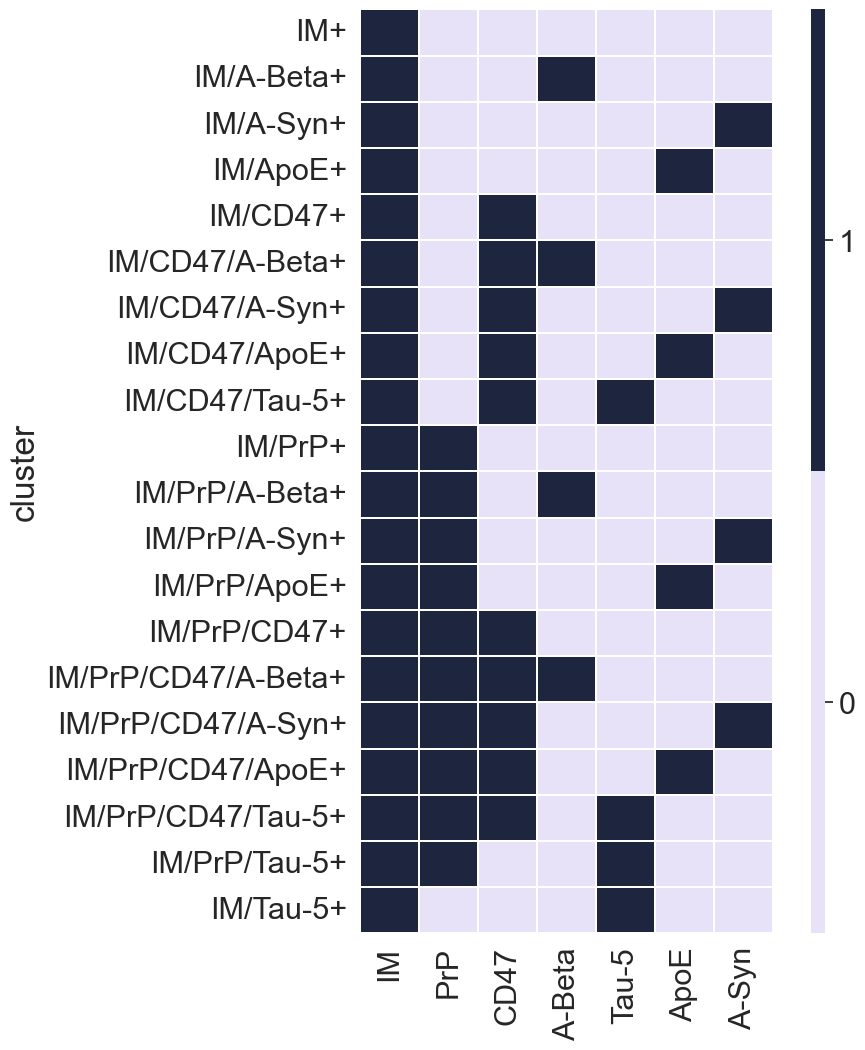

In [134]:
from matplotlib.colors import ListedColormap
mat = coloc_df[cols+["cluster"]].groupby(["cluster"]).mean()
mat[mat>0] = 1
cmap = sns.cubehelix_palette(start=2.8, rot=.1, light=0.9, n_colors=2)
grid_kws = {'width_ratios': (0.9, 0.03), 'wspace': 0.18}
fig, (ax, cbar_ax) = plt.subplots(1, 2, figsize=(6, 12), gridspec_kw=grid_kws)
sns.heatmap(mat, cmap=ListedColormap(cmap), ax=ax,cbar_ax=cbar_ax,linewidth=0.2)
cbar_ax.set_yticklabels(['0', '1'])
cbar_ax.yaxis.set_ticks([ 0.25, 0.75])

In [160]:
coloc_df

Unnamed: 0   spot  A-Beta   CD47    PrP         IM marker samples   
0                 0  Spot4     0.0    0.0    0.0  50.350120   CD63       9  \
2                 2  Spot4     0.0    0.0    0.0  50.520433   CD63       9   
3                 3  Spot4     0.0    0.0    0.0  51.116215   CD63       9   
5                 5  Spot4     0.0    0.0    0.0  58.645589   CD63       9   
6                 6  Spot4     0.0    0.0    0.0  60.627688   CD63       9   
...             ...    ...     ...    ...    ...        ...    ...     ...   
4382300     1673711  Spot3     0.0  318.0  466.0  51.233810   CD81      66   
4382917     1674328  Spot3     0.0  318.0  530.0  60.900835   CD81      66   
4382921     1674332  Spot3     0.0  250.0  774.0  78.601611   CD81      66   
4389834     1681245  Spot8     0.0  295.0  446.0  56.777675    CD9      66   
4391493     1682904  Spot8     0.0  831.0  491.0  57.120720    CD9      66   

         batch  panel  ...  A-Syn  ApoE   TPAD ID Linkcode  Cohort Diagnosis   
0            1      1  ...    0.0   0.0  TPAD0491   141362  Poston        HC  \
2            1      1  ...    0.0   0.0  TPAD0491   141362  Poston        HC   
3            1      1  ...    0.0   0.0  TPAD0491   141362  Poston        HC   
5            1      1  ...    0.0   0.0  TPAD0491   141362  Poston        HC   
6            1      1  ...    0.0   0.0  TPAD0491   141362  Poston        HC   
...        ...    ...  ...    ...   ...       ...      ...     ...       ...   
4382300      6      3  ...  324.0   0.0  TPAD0445   141070  Poston       PDD   
4382917      6      3  ...  323.0   0.0  TPAD0445   141070  Poston       PDD   
4382921      6      3  ...  398.0   0.0  TPAD0445   141070  Poston       PDD   
4389834      6      3  ...  470.0   0.0  TPAD0445   141070  Poston       PDD   
4391493      6      3  ...  355.0   0.0  TPAD0445   141070  Poston       PDD   

        PID 1-90 Prp+  Prp/Cd47+             cluster  
0              9    0          0                 IM+  
2              9    0          0                 IM+  
3              9    0          0                 IM+  
5              9    0          0                 IM+  
6              9    0          0                 IM+  
...          ...  ...        ...                 ...  
4382300       66    1          1  IM/PrP/CD47/A-Syn+  
4382917       66    1          1  IM/PrP/CD47/A-Syn+  
4382921       66    1          1  IM/PrP/CD47/A-Syn+  
4389834       66    1          1  IM/PrP/CD47/A-Syn+  
4391493       66    1          1  IM/PrP/CD47/A-Syn+  

[6046757 rows x 21 columns]

panel  Diagnosis  samples  marker  spot    cluster     
1      AD         31       CD63    Spot4   IM+             0.923351
                                           IM/A-Beta+      0.005348
                                           IM/CD47+        0.017825
                                           IM/PrP+         0.051693
                                           IM/PrP/CD47+    0.001783
                                                             ...   
4      PDD        90       MIgG    Spot10  IM/ApoE+        0.055556
                                           IM/CD47+        0.055556
                                   Spot11  IM+             0.875000
                                           IM/ApoE+        0.125000
                                   Spot12  IM+             1.000000
Length: 18246, dtype: float64

In [701]:
groupby_cols_cluster = ["cluster", 'panel', "Diagnosis", 'samples', "marker", "spot"]
groupby_cols= [ 'panel', "Diagnosis", 'samples', "marker", "spot"]

# df_plt = (coloc_df.groupby(groupby_cols_cluster).size().reset_index(level=0)).rename({0:"# of exosome per cluster"}, axis=1)
# df_tot_ = pd.DataFrame(coloc_df.groupby(groupby_cols).size()).rename({0:"# of exosome per spot"}, axis=1)

# df_plt["Fraction of particles per cluster"] = (df_plt["# of exosome per cluster"]/df_tot_["# of exosome per spot"])#.values
y = "Fraction of particles per cluster"
df_plt = coloc_df.groupby(groupby_cols_cluster).size()/coloc_df.groupby(groupby_cols).size()
df_plt = df_plt.reset_index()
df_plt.rename({0:y}, axis=1, inplace=True)
df_plt

panel Diagnosis samples marker    spot       cluster   
0          1        AD      31   CD63   Spot4           IM+  \
1          1        AD      31   CD63   Spot4    IM/A-Beta+   
2          1        AD      31   CD63   Spot4      IM/CD47+   
3          1        AD      31   CD63   Spot4       IM/PrP+   
4          1        AD      31   CD63   Spot4  IM/PrP/CD47+   
...      ...       ...     ...    ...     ...           ...   
18241      4       PDD      90   MIgG  Spot10      IM/ApoE+   
18242      4       PDD      90   MIgG  Spot10      IM/CD47+   
18243      4       PDD      90   MIgG  Spot11           IM+   
18244      4       PDD      90   MIgG  Spot11      IM/ApoE+   
18245      4       PDD      90   MIgG  Spot12           IM+   

       Fraction of particles per cluster  
0                               0.923351  
1                               0.005348  
2                               0.017825  
3                               0.051693  
4                               0.001783  
...                                  ...  
18241                           0.055556  
18242                           0.055556  
18243                           0.875000  
18244                           0.125000  
18245                           1.000000  

[18246 rows x 7 columns]

In [702]:
sort = pd.DataFrame(df_plt.groupby("cluster")[y].mean()).sort_values(y,ascending=False).index
gg = pd.DataFrame(df_plt.groupby(["cluster"])[y].mean()).sort_values(y,ascending=False)
gg

Fraction of particles per cluster
cluster                                               
IM+                                           0.812129
IM/PrP+                                       0.170520
IM/ApoE+                                      0.032774
IM/A-Syn+                                     0.020562
IM/A-Beta+                                    0.012097
IM/CD47+                                      0.011460
IM/PrP/A-Syn+                                 0.011184
IM/Tau-5+                                     0.010909
IM/PrP/Tau-5+                                 0.007111
IM/PrP/CD47+                                  0.006426
IM/PrP/A-Beta+                                0.006390
IM/PrP/ApoE+                                  0.004757
IM/CD47/ApoE+                                 0.001895
IM/PrP/CD47/ApoE+                             0.001356
IM/PrP/CD47/A-Beta+                           0.001323
IM/CD47/A-Syn+                                0.001038
IM/PrP/CD47/Tau-5+                            0.001013
IM/PrP/CD47/A-Syn+                            0.000997
IM/CD47/Tau-5+                                0.000827
IM/CD47/A-Beta+                               0.000607

MIgG
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

IM/PrP/ApoE+_AD vs. IM/PrP/ApoE+_HC: Mann-Whitney-Wilcoxon test two-sided, P_val:1.936e-04 U_stat=1.510e+04
IM/CD47/ApoE+_AD vs. IM/CD47/ApoE+_HC: Mann-Whitney-Wilcoxon test two-sided, P_val:5.011e-01 U_stat=1.468e+03
IM/PrP/CD47/ApoE+_AD vs. IM/PrP/CD47/ApoE+_HC: Mann-Whitney-Wilcoxon test two-sided, P_val:2.220e-01 U_stat=9.125e+02
IM/ApoE+_HC vs. IM/ApoE+_PDD: Mann-Whitney-Wilcoxon test two-sided, P_val:2.666e-02 U_stat=3.703e+04
IM/PrP/ApoE+_HC vs. IM/PrP/ApoE+_PDD: Mann-Whitney-Wilcoxon test two-sided, P_val:1.955e-02 U_stat=2.226e+04
IM/CD47/ApoE+_HC vs. IM/CD47/ApoE+_PDD: Mann-Whitney-Wilcoxon test two-sided, P_val:1.146e-01 U_stat=2.030e+03
IM/PrP/CD47/ApoE+_HC vs. IM/PrP/CD47/ApoE+_PDD: Mann-Whitney-Wilcoxon test two-sided, P_val:5.125e-02 U_stat=1.060e+03
IM/PrP+_AD vs. IM/PrP+_HC: Mann-Whitne

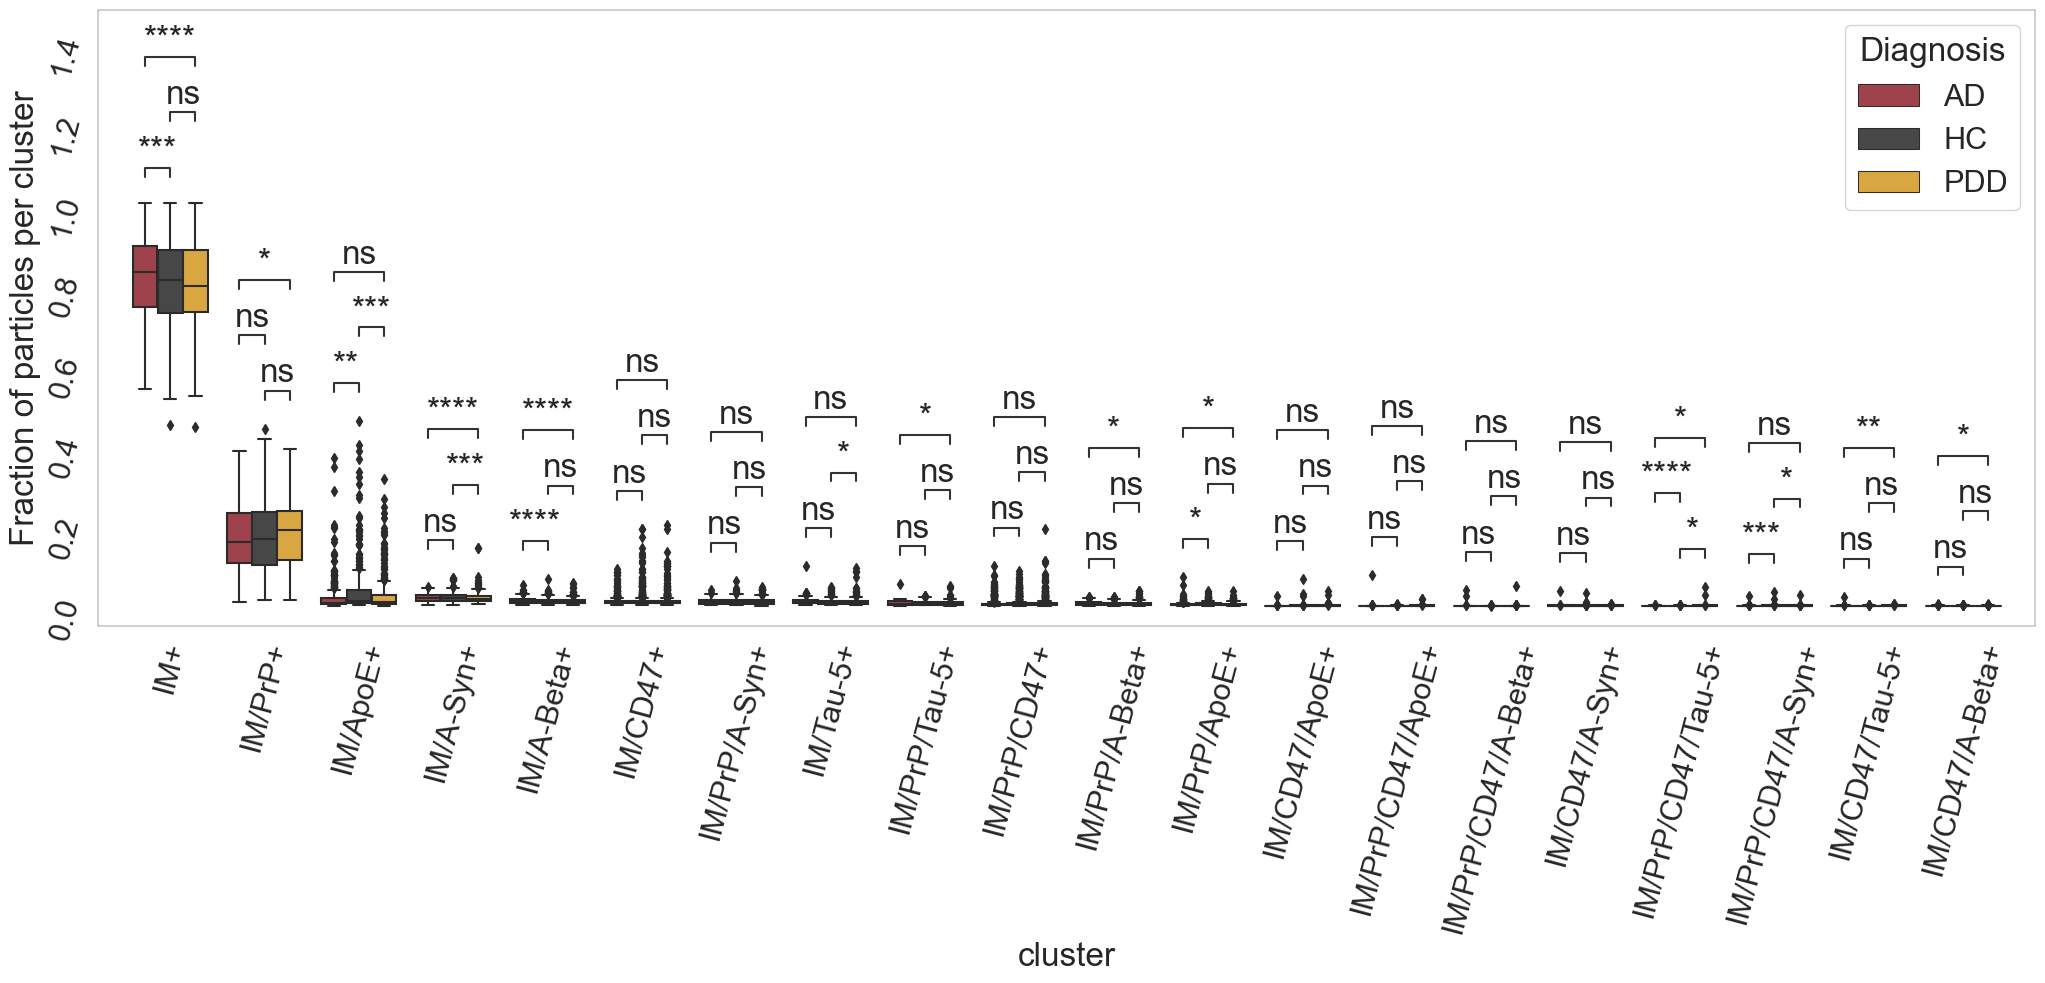

In [703]:
fig, ax = plt.subplots(figsize=(25, 8))
list_cl = gg.index.tolist()
x = "cluster"
hue="Diagnosis"
sns.boxplot(data=df_plt, x=x, y=y, hue=hue, palette=palette_diagnosis, ax=ax, order=list_cl)
pairs = [((cl,"AD"),(cl, "HC")) for cl in list_cl ]
pairs +=[((cl,"PDD"),(cl, "HC")) for cl in list_cl ] 
pairs +=[((cl,"PDD"),(cl, "AD")) for cl in list_cl ] 

#for name,ax in g.axes_dict.items():
if True:
#         ax = g.ax
        print(name)
# # subset the table otherwise the stats were calculated on the whole dataset
        tmp = df_plt#[df_plt[col]==name]
        annot = Annotator(ax, pairs, data=tmp, x=x, y=y,hue=hue ) 
        annot.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
        annot.apply_test().annotate()
        #ax.set_xlabel("")

plt.tick_params(rotation=75)


CD63
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

IM/Tau-5+_AD vs. IM/Tau-5+_HC: Mann-Whitney-Wilcoxon test two-sided, P_val:1.360e-01 U_stat=2.084e+03
IM/Tau-5+_HC vs. IM/Tau-5+_PDD: Mann-Whitney-Wilcoxon test two-sided, P_val:4.249e-01 U_stat=1.647e+03
IM/Tau-5+_AD vs. IM/Tau-5+_PDD: Mann-Whitney-Wilcoxon test two-sided, P_val:5.040e-01 U_stat=1.992e+03
CD81
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

IM/Tau-5+_AD vs. IM/Tau-5+_HC: Mann-Whitney-Wilcoxon test two-sided, P_val:6.446e-01 U_stat=2.314e+03
IM/Tau-5+_HC vs. IM/Tau-5+_PDD: Mann-Whitney-Wilcoxon test two-sided, P_val:1.508e-01 U_stat=2.421e+03
IM/Tau-5+_AD vs. IM/Tau-5+_PDD: Mann-Whitney-Wilcoxon test two-sided, P_val:9.419e-02 U_stat=2.508e+03
CD9
p-value 

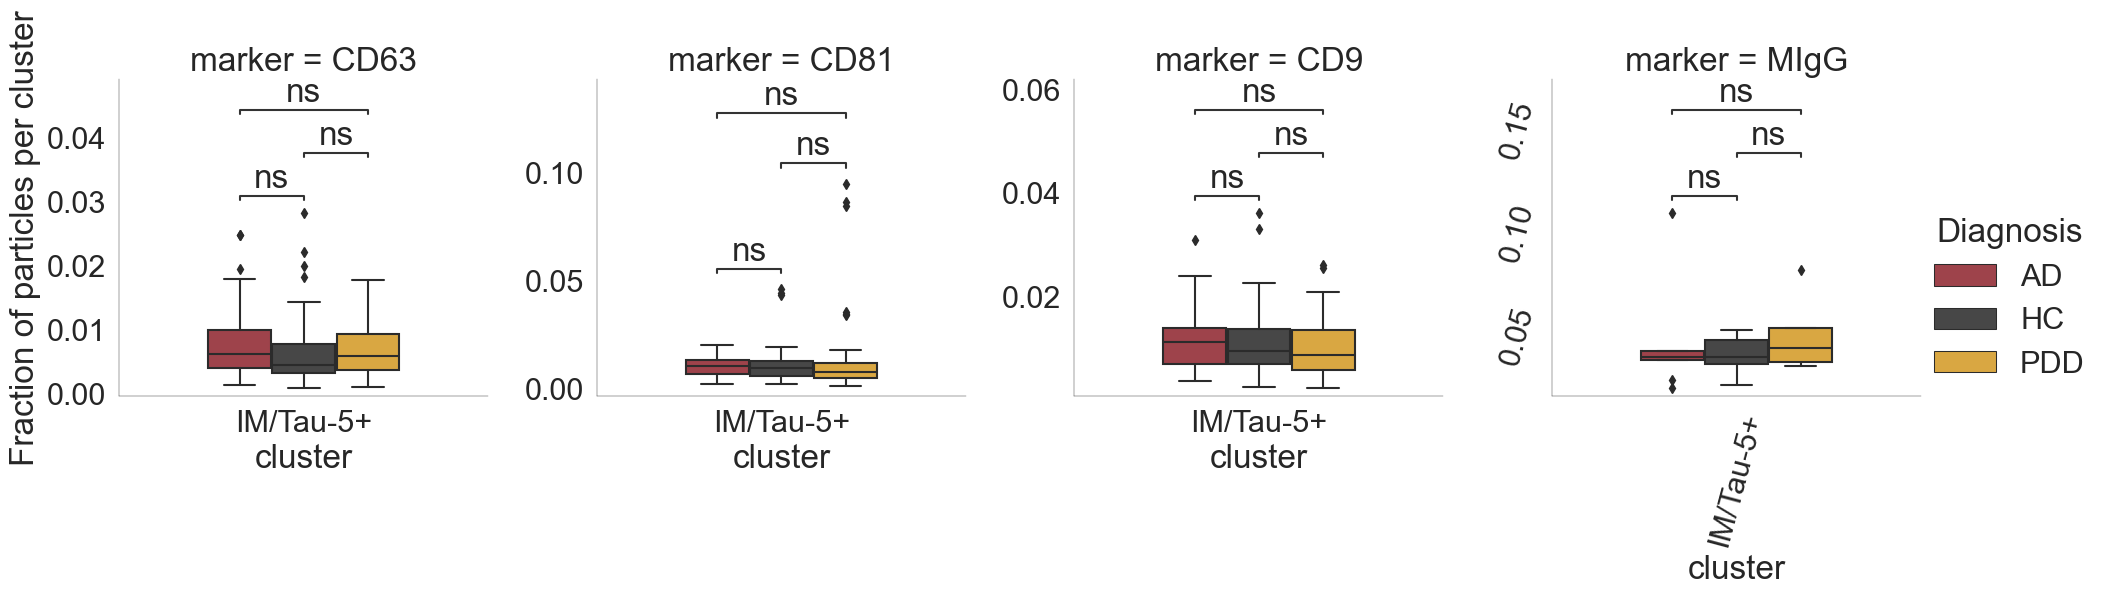

In [708]:
#fig, ax = plt.subplots()#figsize=(10, 8))
list_cl = gg.index.tolist()
x = "cluster"
hue="Diagnosis"
it = "IM/Tau-5+"
col = "marker"
g = sns.catplot(data=df_plt[df_plt.cluster==it], x=x, y=y, hue=hue, palette=palette_diagnosis, col=col, kind="box",sharey=False)# order=list_cl)
pairs = [((cl,"AD"),(cl, "HC")) for cl in [it] ]
pairs +=[((cl,"PDD"),(cl, "HC")) for cl in [it]  ] 
pairs +=[((cl,"PDD"),(cl, "AD")) for cl in [it]  ] 

for name,ax in g.axes_dict.items():
#if True:
#        #ax = g.ax
        print(name)
# # subset the table otherwise thestats were calculated on the whole dataset
        tmp = df_plt[(df_plt.cluster==it)&(df_plt[col]==name)]
        annot = Annotator(ax, pairs, data=tmp, x=x, y=y,hue=hue ) 
        annot.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
        annot.apply_test().annotate()
        #ax.set_xlabel("")

plt.tick_params(rotation=75)

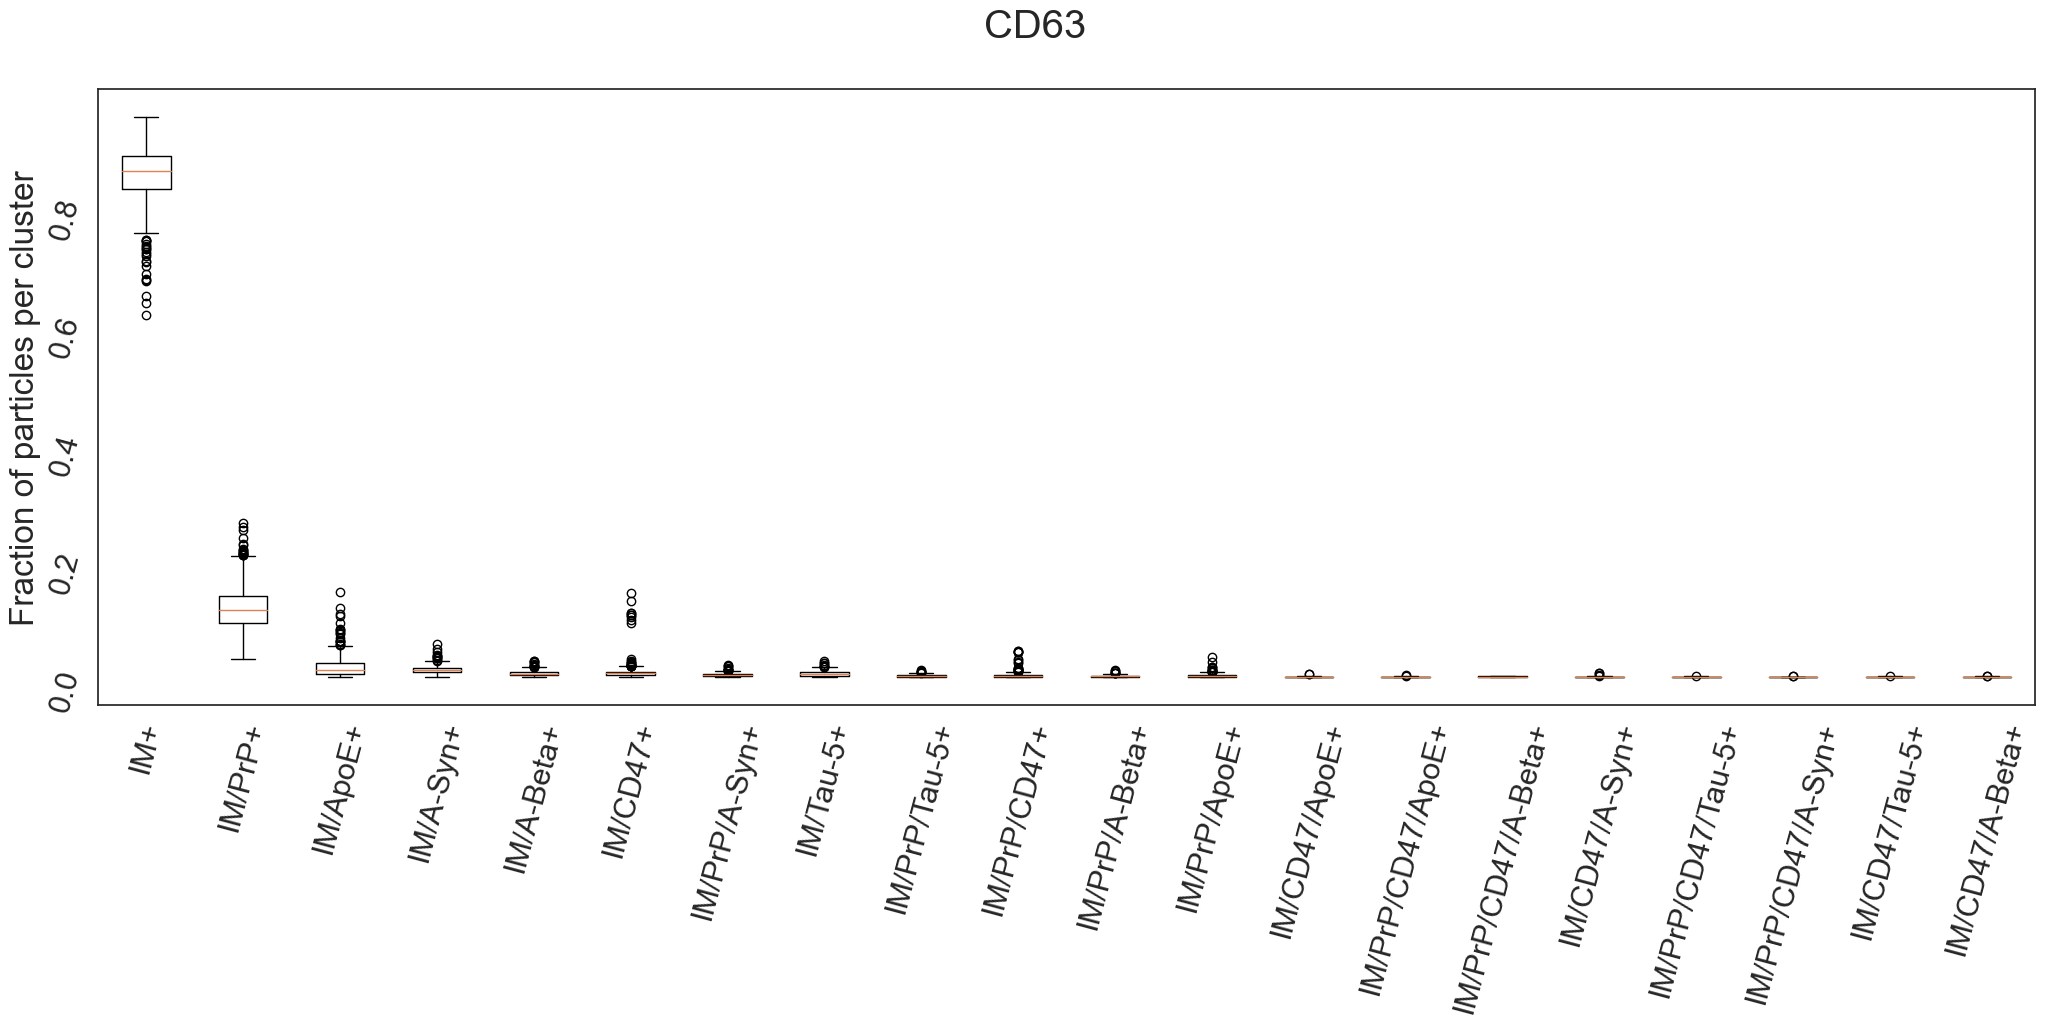

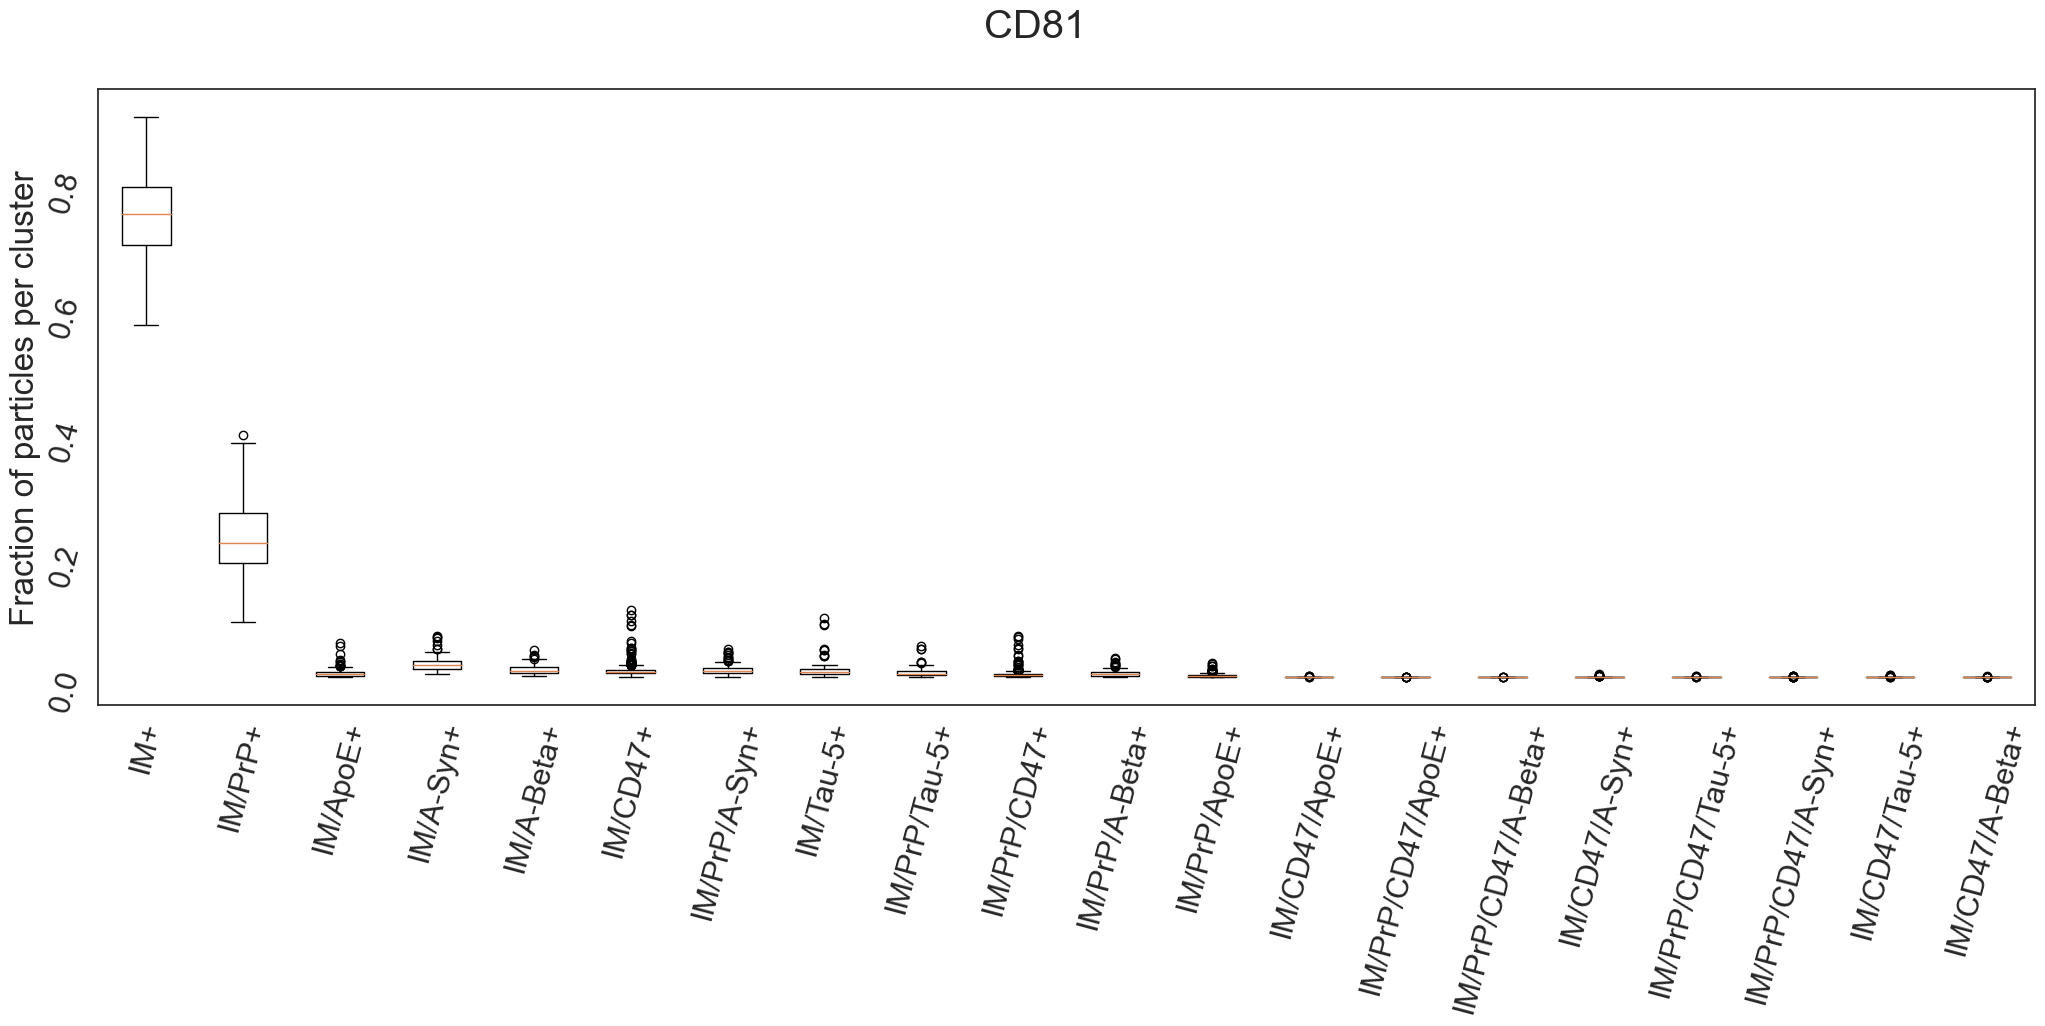

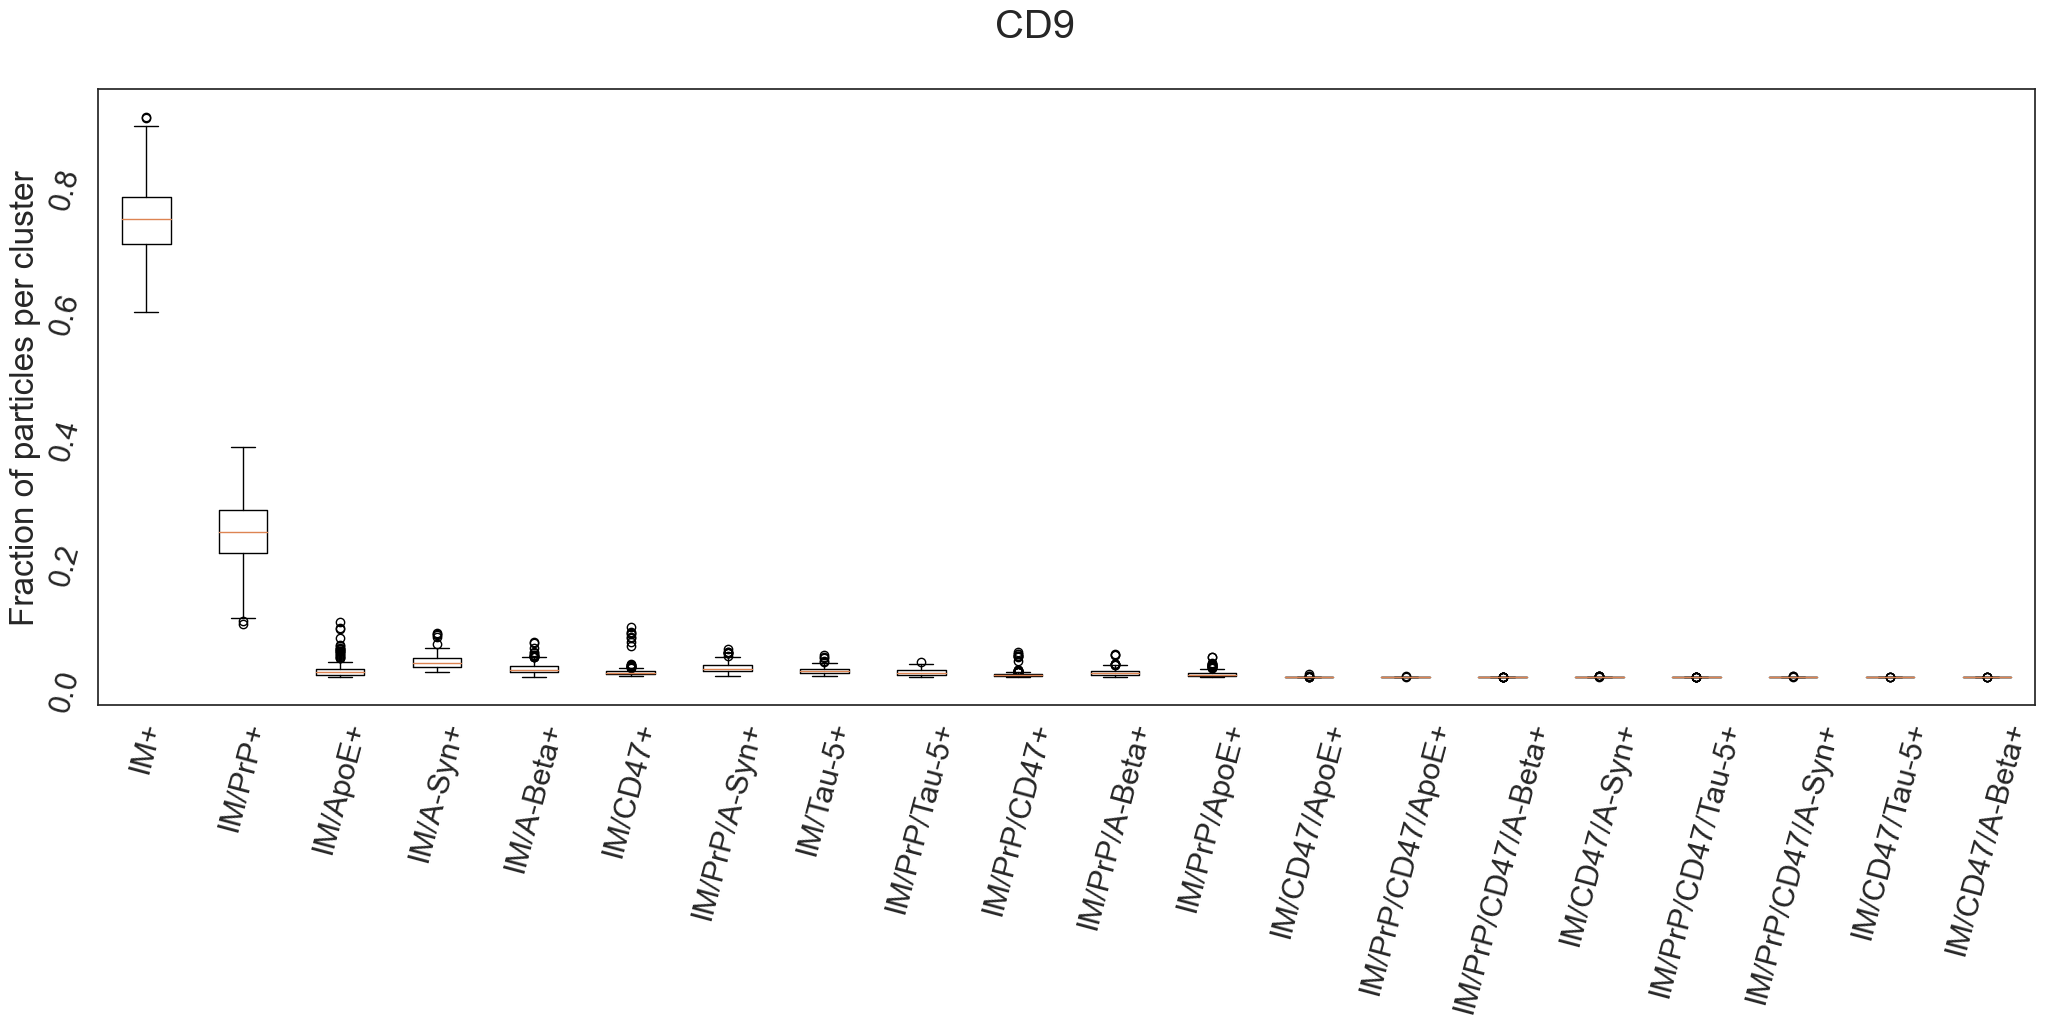

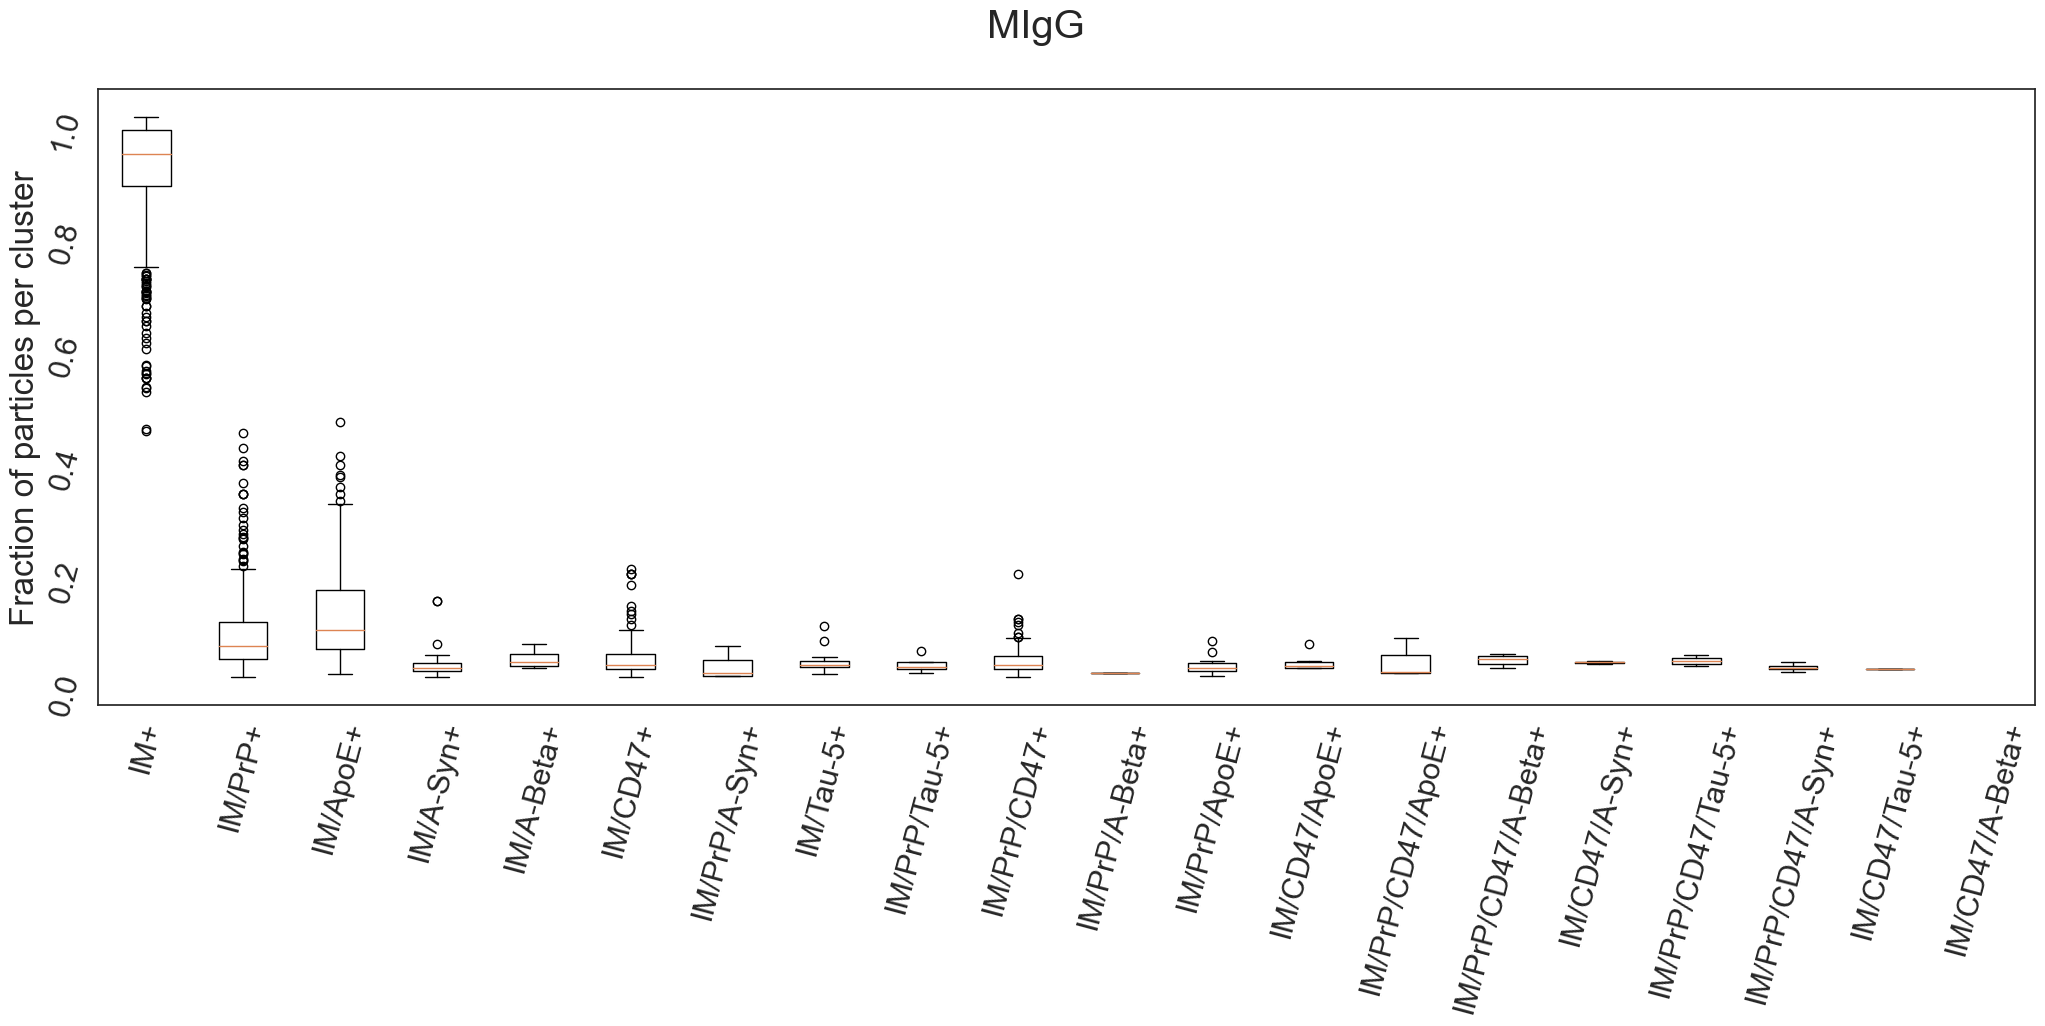

In [209]:

for it in df_plt.marker.unique():
    tmp =df_plt[df_plt.marker==it]
    fig, ax = plt.subplots(figsize=(25, 8))
    ax.boxplot([tmp[tmp.cluster ==it][y] for it in sort], labels=sort)
    plt.tick_params(rotation=75)
    ax.set_ylabel(y)
    plt.suptitle(it)
    plt.show()


In [769]:
df

Unnamed: 0    spot  A-Beta  CD47    PrP         IM marker samples   
0                 0   Spot4     0.0   0.0    0.0  50.350120   CD63       9  \
1                 1   Spot4     0.0   0.0  624.0  50.389418   CD63       9   
2                 2   Spot4     0.0   0.0    0.0  50.520433   CD63       9   
3                 3   Spot4     0.0   0.0    0.0  51.116215   CD63       9   
4                 4   Spot4     0.0   0.0  491.0  55.023671   CD63       9   
...             ...     ...     ...   ...    ...        ...    ...     ...   
6394615     1725898  Spot12     NaN   0.0    0.0  56.603524   MIgG      58   
6394616     1725899  Spot12     NaN   0.0    0.0  51.135725   MIgG      58   
6394617     1725900  Spot12     NaN   0.0    0.0  51.770379   MIgG      58   
6394618     1725901  Spot12     NaN   0.0  543.0  51.780516   MIgG      58   
6394619     1725902  Spot12     NaN   0.0    0.0  53.537604   MIgG      58   

         batch  panel  Tau-5  A-Syn  ApoE   TPAD ID Linkcode  Cohort   
0            1      1    NaN    NaN   NaN  TPAD0491   141362  Poston  \
1            1      1    NaN    NaN   NaN  TPAD0491   141362  Poston   
2            1      1    NaN    NaN   NaN  TPAD0491   141362  Poston   
3            1      1    NaN    NaN   NaN  TPAD0491   141362  Poston   
4            1      1    NaN    NaN   NaN  TPAD0491   141362  Poston   
...        ...    ...    ...    ...   ...       ...      ...     ...   
6394615      6      4    NaN    NaN   0.0  TPAD0367     1211    ADRC   
6394616      6      4    NaN    NaN   0.0  TPAD0367     1211    ADRC   
6394617      6      4    NaN    NaN   0.0  TPAD0367     1211    ADRC   
6394618      6      4    NaN    NaN   0.0  TPAD0367     1211    ADRC   
6394619      6      4    NaN    NaN   0.0  TPAD0367     1211    ADRC   

        Diagnosis PID 1-90  Prp+  Prp/Cd47+  
0              HC        9     0          0  
1              HC        9     1          0  
2              HC        9     0          0  
3              HC        9     0          0  
4              HC        9     1          0  
...           ...      ...   ...        ...  
6394615        AD       58     0          0  
6394616        AD       58     0          0  
6394617        AD       58     0          0  
6394618        AD       58     1          0  
6394619        AD       58     0          0  

[6046757 rows x 20 columns]

In [974]:
bin_df = coloc_df.copy()
cols = [ 'PrP', 'CD47','A-Beta', "Tau-5",  "A-Syn","ApoE"]
for it in cols:
    bin_df.loc[bin_df[it]>0, it] = 1
    
groupby_cols_cluster = ["cluster", 'panel', "Diagnosis", 'samples', "marker", "spot"]

#sns.clustermap(coloc_df[coloc_df["cluster"] != "IM+"].groupby(groupby_cols_cluster)[cols].mean().T.corr())
groupby_cols_cluster = ["cluster", 'panel', "Diagnosis", 'samples', "marker", "spot"]
groupby_cols_sp = ["cluster", 'panel', "Diagnosis", 'samples', "marker"]
groupby_cols_sp = ["cluster",  "Diagnosis", 'samples', "marker",]
groupby_cols_sp = [ "Diagnosis", 'samples',  "cluster","panel"] #"marker","panel"]

df_tt = coloc_df[(coloc_df["cluster"] != "IM+")]
df_tt = df_tt[(df_tt["marker"] != "MIgG")]
#print(df_tt)
#df_tt = df_tt.groupby(groupby_cols_cluster)[cols].mean().reset_index()#.groupby(groupby_cols_sp)[cols].median().reset_index()
#df_tt = df_tt.groupby(groupby_cols_sp)[cols].median().reset_index()#.groupby(groupby_cols_sp)[cols].median().reset_index()

#df_tt = bin_df[bin_df["cluster"] != "IM+"].groupby(groupby_cols_cluster)[cols].mean().reset_index()#.groupby(groupby_cols_sp)[cols].median().reset_index()

#df_ttmain = df_tt.sample(frac=1)
print(df_ttmain)

#df_ttmain["panel"] = df_ttmain["panel"].astype(str)


             cluster  panel Diagnosis samples marker   spot          PrP   
1898        IM/ApoE+      4       PDD      87   CD63  Spot5     0.000000  \
9549    IM/PrP/CD47+      1        AD      33   CD63  Spot4  2379.333333   
12640  IM/PrP/Tau-5+      2        AD      44    CD9  Spot8   601.111111   
752        IM/A-Syn+      3        AD      43    CD9  Spot7     0.000000   
1795        IM/ApoE+      4       PDD      72    CD9  Spot9     0.000000   
...              ...    ...       ...     ...    ...    ...          ...   
2978        IM/CD47+      2        HC       5   CD63  Spot6     0.000000   
9987    IM/PrP/CD47+      1       PDD      64    CD9  Spot7   827.000000   
2828        IM/CD47+      2        HC       1    CD9  Spot9     0.000000   
6624         IM/PrP+      3        AD      49   CD63  Spot6   695.488000   
10523   IM/PrP/CD47+      2        HC       8   CD63  Spot5   631.333333   

             CD47  A-Beta       Tau-5       A-Syn        ApoE  
1898     0.000000     0

In [975]:
import anndata as ad
adata = ad.AnnData(df_tt[cols])
for it in groupby_cols_cluster:
    adata.obs[it] = df_tt[it].values

/Users/eloiseberson/anaconda3/envs/jupyter/lib/python3.10/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [ ]:
import scanpy as sc
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

/Users/eloiseberson/anaconda3/envs/jupyter/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/eloiseberson/anaconda3/envs/jupyter/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [ ]:
sc.pl.pca(adata, color=["cluster", "panel", "Diagnosis"],size=60, wspace=1)
sc.pl.umap(adata, color=["cluster", "panel", "Diagnosis"],size=60, wspace=1)


In [948]:
columnnng = [ "cluster","panel" ]#, ,["marker", "panel", "cluster"], #,
#"cluster" ,
df_ttmain["panel"] = df_ttmain["panel"].astype(str)
new_df = df_ttmain.pivot(index=["Diagnosis", "samples"], columns=columnnng) #[pivot_table(index=["Diagnosis", "samples"], values=cols)
new_df.columns = new_df.columns.map('_'.join)
new_df = new_df.reset_index().fillna(0)
new_df

Diagnosis samples  PrP_IM/CD47+_1  PrP_IM/PrP/CD47/ApoE+_4   
0         AD      31             0.0                  1166.00  \
1         AD      32             0.0                     0.00   
2         AD      33             0.0                     0.00   
3         AD      34             0.0                     0.00   
4         AD      35             0.0                  1437.00   
..       ...     ...             ...                      ...   
84       PDD      86             0.0                   534.00   
85       PDD      87             0.0                     0.00   
86       PDD      88             0.0                   700.00   
87       PDD      89             0.0                   971.75   
88       PDD      90             0.0                  1563.75   

    PrP_IM/A-Syn+_3  PrP_IM/CD47+_4  PrP_IM/CD47+_2  PrP_IM/PrP/CD47+_4   
0               0.0             0.0             0.0          685.428571  \
1               0.0             0.0             0.0          687.283333   
2               0.0             0.0             0.0          669.250000   
3               0.0             0.0             0.0          663.714286   
4               0.0             0.0             0.0          828.034965   
..              ...             ...             ...                 ...   
84              0.0             0.0             0.0          713.571429   
85              0.0             0.0             0.0          745.750000   
86              0.0             0.0             0.0          657.125000   
87              0.0             0.0             0.0          785.937198   
88              0.0             0.0             0.0          644.000000   

    PrP_IM/PrP+_1  PrP_IM/CD47/A-Beta+_1  ...  ApoE_IM/PrP/Tau-5+_2   
0      648.319149                    0.0  ...                   0.0  \
1      716.704394                    0.0  ...                   0.0   
2      700.375000                    0.0  ...                   0.0   
3      637.148688                    0.0  ...                   0.0   
4      712.392015                    0.0  ...                   0.0   
..            ...                    ...  ...                   ...   
84     688.170004                    0.0  ...                   0.0   
85     633.469577                    0.0  ...                   0.0   
86    1036.456186                    0.0  ...                   0.0   
87     952.416431                    0.0  ...                   0.0   
88     762.907216                    0.0  ...                   0.0   

    ApoE_IM/PrP/A-Beta+_1  ApoE_IM/PrP/CD47/Tau-5+_2   
0                     0.0                        0.0  \
1                     0.0                        0.0   
2                     0.0                        0.0   
3                     0.0                        0.0   
4                     0.0                        0.0   
..                    ...                        ...   
84                    0.0                        0.0   
85                    0.0                        0.0   
86                    0.0                        0.0   
87                    0.0                        0.0   
88                    0.0                        0.0   

    ApoE_IM/PrP/CD47/A-Syn+_3  ApoE_IM/PrP/CD47+_3  ApoE_IM/PrP+_3   
0                         0.0                  0.0             0.0  \
1                         0.0                  0.0             0.0   
2                         0.0                  0.0             0.0   
3                         0.0                  0.0             0.0   
4                         0.0                  0.0             0.0   
..                        ...                  ...             ...   
84                        0.0                  0.0             0.0   
85                        0.0                  0.0             0.0   
86                        0.0                  0.0             0.0   
87                        0.0                  0.0             0.0   
88                       

In [951]:

from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import StratifiedKFold
col_to_use = new_df.iloc[:, 2:].sum()[new_df.iloc[:, 2:].sum()>0].index.tolist()
print(len(col_to_use))
## prediction AD, NC
df_tt = new_df[new_df["Diagnosis"].isin(["AD", "HC"])].reset_index(drop=True)
label = df_tt["samples"].values
X = df_tt.loc[:,col_to_use].values
y = df_tt["Diagnosis"].map({"HC":0,"AD":1}).values


models = ['LASSO', 'Ridge', 'EN', 'Random Forest', "XGBoost"]#, "KNN"]
res = pd.DataFrame(np.zeros((len(models), 2)), index=models, columns=['AUC', 'P-value'])
y_preds = {k:pd.DataFrame(np.zeros((len(y), 1)), columns=['y_pred']) for k in models}
for algo in models:
    loo = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    for train_index, test_index in loo.split(X,y):
        models = {
                    'EN': LogisticRegression(penalty='elasticnet', l1_ratio=0.5, fit_intercept=False, solver='saga', max_iter=10000), #'EN': customLogisticRegressionCV(cv=5, l1_ratios=[0, 0.25, 0.5, 0.75, 1], fit_intercept=False),
                    'LASSO': LogisticRegression(penalty='l1', fit_intercept=False, solver='saga', max_iter=10000), #customLogisticRegressionCV(cv=5, l1_ratios=[1], fit_intercept=False), #
                    'Ridge': LogisticRegression(penalty='l2', fit_intercept=False), #customLogisticRegressionCV(cv=5, l1_ratios=[0], fit_intercept=False), #
                    'Random Forest': RandomForestClassifier(),
                    'KNN': KNeighborsClassifier(),
                    #'SVM': SVC(probability=True),  #rbf for AD, linear for LBD
                    'XGBoost': XGBClassifier(n_jobs=-1, booster='gblinear', objective='binary:logistic')
                }
        clf = models[algo]
        pipe = Pipeline([#("scale", StandardScaler()),
                  #("reduce_dims", PCA()),
                 ("model", clf)
                 ])
        X_train, X_test = X[train_index, :], X[test_index, :]
        y_train, y_test = y[train_index], y[test_index]
        pipe.fit(np.array(X_train), np.array(y_train))
        # if algo in ['LASSO', 'Ridge']:
            # y_pred = np.array(clf.best_estimator_.predict_proba(np.array(X_test))[:, 1])
        # else:
        y_pred = np.array(pipe.predict_proba(np.array(X_test))[:, 1])
        y_preds[algo].loc[test_index, :] = y_pred.reshape((-1,1))
    # evaluation
    res.loc[algo, 'P-value'] = mannwhitneyu(y_preds[algo][y==0], y_preds[algo][y==1]).pvalue
    res.loc[algo, 'AUC'] = roc_auc_score(y, y_preds[algo])
    print(res.loc[algo, 'AUC'])
    print(res.loc[algo, 'P-value'])
    print("\n")

48
0.6355555555555555
0.07244559577423665


0.6277777777777778
0.0879815635634918




/Users/eloiseberson/anaconda3/envs/jupyter/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/eloiseberson/anaconda3/envs/jupyter/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

0.6355555555555555
0.07244559577423665


0.5722222222222223
0.339878878696271


0.5955555555555555
0.20439788903473421




In [952]:
col_to_use = new_df.iloc[:, 2:].sum()[new_df.iloc[:, 2:].sum()>0].index.tolist()
print(len(col_to_use))
## prediction AD, NC
df_tt = new_df[new_df["Diagnosis"].isin(["PDD", "HC"])].reset_index(drop=True)
label = df_tt["samples"].values
X = df_tt.loc[:,col_to_use].values
y = df_tt["Diagnosis"].map({"HC":0,"PDD":1}).values


models = ['LASSO', 'Ridge', 'EN', 'Random Forest', "XGBoost"]
res = pd.DataFrame(np.zeros((len(models), 2)), index=models, columns=['AUC', 'P-value'])
y_preds = {k:pd.DataFrame(np.zeros((len(y), 1)), columns=['y_pred']) for k in models}
for algo in models:
    loo = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    for train_index, test_index in loo.split(X,y):
        models = {
                    'EN': LogisticRegression(penalty='elasticnet', l1_ratio=0.5, fit_intercept=False, solver='saga', max_iter=10000), #'EN': customLogisticRegressionCV(cv=5, l1_ratios=[0, 0.25, 0.5, 0.75, 1], fit_intercept=False),
                    'LASSO': LogisticRegression(penalty='l1', fit_intercept=False, solver='saga', max_iter=10000), #customLogisticRegressionCV(cv=5, l1_ratios=[1], fit_intercept=False), #
                    'Ridge': LogisticRegression(penalty='l2', fit_intercept=False), #customLogisticRegressionCV(cv=5, l1_ratios=[0], fit_intercept=False), #
                    'Random Forest': RandomForestClassifier(),
                    'KNN': KNeighborsClassifier(),
                    #'SVM': SVC(probability=True),  #rbf for AD, linear for LBD
                    'XGBoost': XGBClassifier(n_jobs=-1, booster='gblinear', objective='binary:logistic')
                }
        clf = models[algo]
        pipe = Pipeline([("scale", StandardScaler()),
                 #("reduce_dims", PCA()),
                 ("model", clf)
                 ])
        X_train, X_test = X[train_index, :], X[test_index, :]
        y_train, y_test = y[train_index], y[test_index]
        pipe.fit(np.array(X_train), np.array(y_train))
        # if algo in ['LASSO', 'Ridge']:
            # y_pred = np.array(clf.best_estimator_.predict_proba(np.array(X_test))[:, 1])
        # else:
        y_pred = np.array(pipe.predict_proba(np.array(X_test))[:, 1])
        y_preds[algo].loc[test_index, :] = y_pred.reshape((-1,1))
    # evaluation
    res.loc[algo, 'P-value'] = mannwhitneyu(y_preds[algo][y==0], y_preds[algo][y==1]).pvalue
    res.loc[algo, 'AUC'] = roc_auc_score(y, y_preds[algo])
    print(res.loc[algo, 'AUC'])
    print(res.loc[algo, 'P-value'])
    print("\n")

48
0.5574712643678161
0.45294335100823446


0.4528735632183908
0.5391760657144591


0.5275862068965518
0.7216113561855784


0.42356321839080463
0.316580683491689


0.4913793103448276
0.9024613351533836




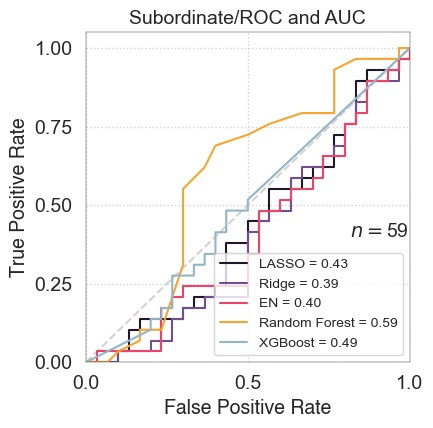

In [930]:
# Compute ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib.figure import figaspect
import matplotlib as mpl

fpr = dict()
tpr = dict()
roc_auc = dict()
gr_truth = y


font = "Arial"
hfont = {'fontname':'Helvetica'}
for i, algo in enumerate(y_preds.keys()):
    fpr[i], tpr[i], _ = roc_curve(gr_truth, np.array(y_preds[algo]))
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.rc('grid', linestyle="dotted", color='lightgray')
color = ['#22162B', '#724E91', '#EE4266', '#f8a530', '#93B5C6']
#color = 
w, h = figaspect(1.)
plt.figure(figsize=(w, h))
mpl.rcParams['axes.linewidth'] = 0.3
lw = 1.5
fontsize = 14
plt.plot([0, 1], [0, 1], color='lightgrey', lw=lw, linestyle='--')
for i, algo in enumerate(y_preds.keys()):
    plt.plot(fpr[i], tpr[i], color=color[i], 
            lw=lw, label='{} = {:.2f}'.format(algo, roc_auc[i]))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=fontsize, fontname=font)
plt.yticks(fontsize=fontsize, fontname=font)
plt.xlabel('False Positive Rate', size=fontsize, **hfont)
plt.ylabel('True Positive Rate', size=fontsize, **hfont)
#plt.title('Mediterrannean/ROC and AUC', size=fontsize)
plt.title('Subordinate/ROC and AUC', size=fontsize)
plt.text(0.815, 0.4, '$\it{n=}$' + str(len(y)), fontsize=fontsize)
plt.legend(loc="lower right", fontsize=fontsize-4)
plt.tight_layout()
plt.grid(True)

In [911]:
gt

TPAD ID Linkcode  Cohort Diagnosis PID 1-90
0   TPAD0473   141236  Poston        HC        1
1   TPAD0450   141091  Poston        HC        2
2   TPAD0494   141370  Poston        HC        3
3   TPAD0490   141361  Poston        HC        4
4   TPAD0471   141229  Poston        HC        5
..       ...      ...     ...       ...      ...
85  TPAD0479   141312  Poston  PD-noMCI       86
86  TPAD0488   141352  Poston  PD-noMCI       87
87  TPAD0298     1013    ADRC  PD-noMCI       88
88  TPAD0318     1072    ADRC  PD-noMCI       89
89  TPAD0370     1222    ADRC  PD-noMCI       90

[90 rows x 5 columns]

In [913]:
#### rerun the best model again for getting prediction values and weights --------------------------------------------------------
y_pred = np.zeros((len(y)))
loo = LeaveOneOut()
k = 5
loo = KFold(n_splits=5, shuffle=True, random_state=0)
wt = np.zeros((5, X.shape[1]))

for i, (train_index, test_index) in enumerate(loo.split(X)):
    clf = models["Ridge"]
    #clf = LogisticRegression(penalty='l2', fit_intercept=False)  
    pipe = Pipeline([ #("scale", StandardScaler()),
                  #("reduce_dims", PCA()),
                 ("model", clf)
                 ])
    X_train, X_test = X[train_index, :], X[test_index, :]
    y_train, y_test = y[train_index], y[test_index]
    pipe.fit(np.array(X_train), np.array(y_train))
    y_pred[test_index] = np.array(pipe.predict_proba(np.array(X_test))[:, 1])#.reshape((-1))
    wt[i,: ] = clf.coef_[0]
    #print(clf.coef_)

# evaluation
p_value = mannwhitneyu(y_pred[y==0], y_pred[y==1]).pvalue
auc = roc_auc_score(y, y_pred)

print(y_pred)


[1.00000000e+000 9.97327569e-001 1.00000000e+000 9.99401046e-001
 9.99999926e-001 8.65011303e-001 1.33093215e-003 9.88024126e-001
 3.09353115e-001 9.99997706e-001 9.99923925e-001 9.99999863e-001
 9.99726364e-001 8.80854639e-001 1.09282623e-005 1.00000000e+000
 1.10160696e-007 3.99318903e-008 9.99684778e-001 9.99992642e-001
 9.99968856e-001 9.99999999e-001 9.88772280e-001 9.99999745e-001
 1.00000000e+000 1.00000000e+000 9.99999933e-001 9.99993378e-001
 1.77730105e-046 1.82122375e-127 6.64428935e-006 8.41815791e-001
 1.05259935e-008 1.57448264e-011 1.00000000e+000 6.37084900e-002
 1.59833090e-004 7.72340180e-004 9.10012610e-018 1.00000000e+000
 4.91197556e-004 1.65027334e-005 2.48561699e-044 9.92573876e-001
 2.83227084e-010 9.97871910e-001 9.83415270e-005 1.72001414e-005
 1.97457241e-008 1.66875626e-017 3.84678380e-008 6.82078233e-013
 6.13050936e-016 5.79848311e-002 2.17664781e-018 9.99998108e-001
 6.76150475e-011 1.01644150e-001 4.77120084e-004]


/Users/eloiseberson/anaconda3/envs/jupyter/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/eloiseberson/anaconda3/envs/jupyter/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

In [914]:
clf.coef_.shape

(1, 144)

In [915]:
p_value

0.0001500152632168934

In [916]:
gt
map_id2dd = {id:gg for id,gg in zip(gt["PID 1-90"], gt["Diagnosis"])}
map_id2cc = {id:gg for id,gg in zip(gt["PID 1-90"], gt["Cohort"])}

gt

TPAD ID Linkcode  Cohort Diagnosis PID 1-90
0   TPAD0473   141236  Poston        HC        1
1   TPAD0450   141091  Poston        HC        2
2   TPAD0494   141370  Poston        HC        3
3   TPAD0490   141361  Poston        HC        4
4   TPAD0471   141229  Poston        HC        5
..       ...      ...     ...       ...      ...
85  TPAD0479   141312  Poston  PD-noMCI       86
86  TPAD0488   141352  Poston  PD-noMCI       87
87  TPAD0298     1013    ADRC  PD-noMCI       88
88  TPAD0318     1072    ADRC  PD-noMCI       89
89  TPAD0370     1222    ADRC  PD-noMCI       90

[90 rows x 5 columns]

No handles with labels found to put in legend.


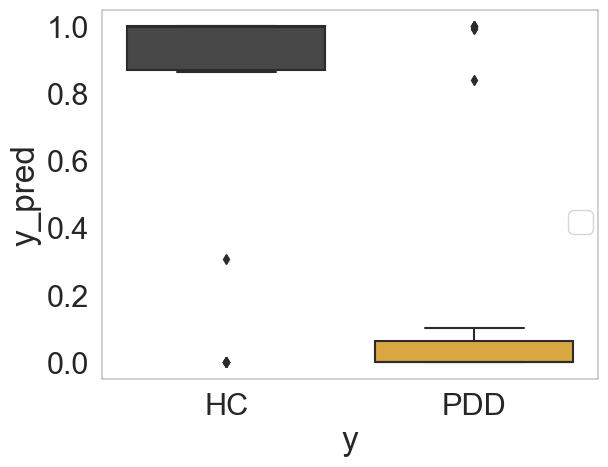

In [917]:
ll = pd.DataFrame({"y_pred":y_pred, "y":y, "label":label})
ll["Cohort"] = ll["label"].map(map_id2cc).values

ll["label"] = ll["label"].map(map_id2dd).values

ll["y"] = ll["y"].map({0:"HC", 1:"PDD"}).values
palette_diagnosis["MCI"] = "#E0E0CE"
palette_diagnosis["PD-MCI"] = "#E0E0CE"
palette_diagnosis["PD-noMCI"] = "#E0E0CE"

ax= sns.boxplot(data=ll, x="y", y="y_pred", palette=palette_diagnosis)
ax.legend(bbox_to_anchor=(1.02,0.5))

<AxesSubplot:xlabel='Mean_weight', ylabel='features'>

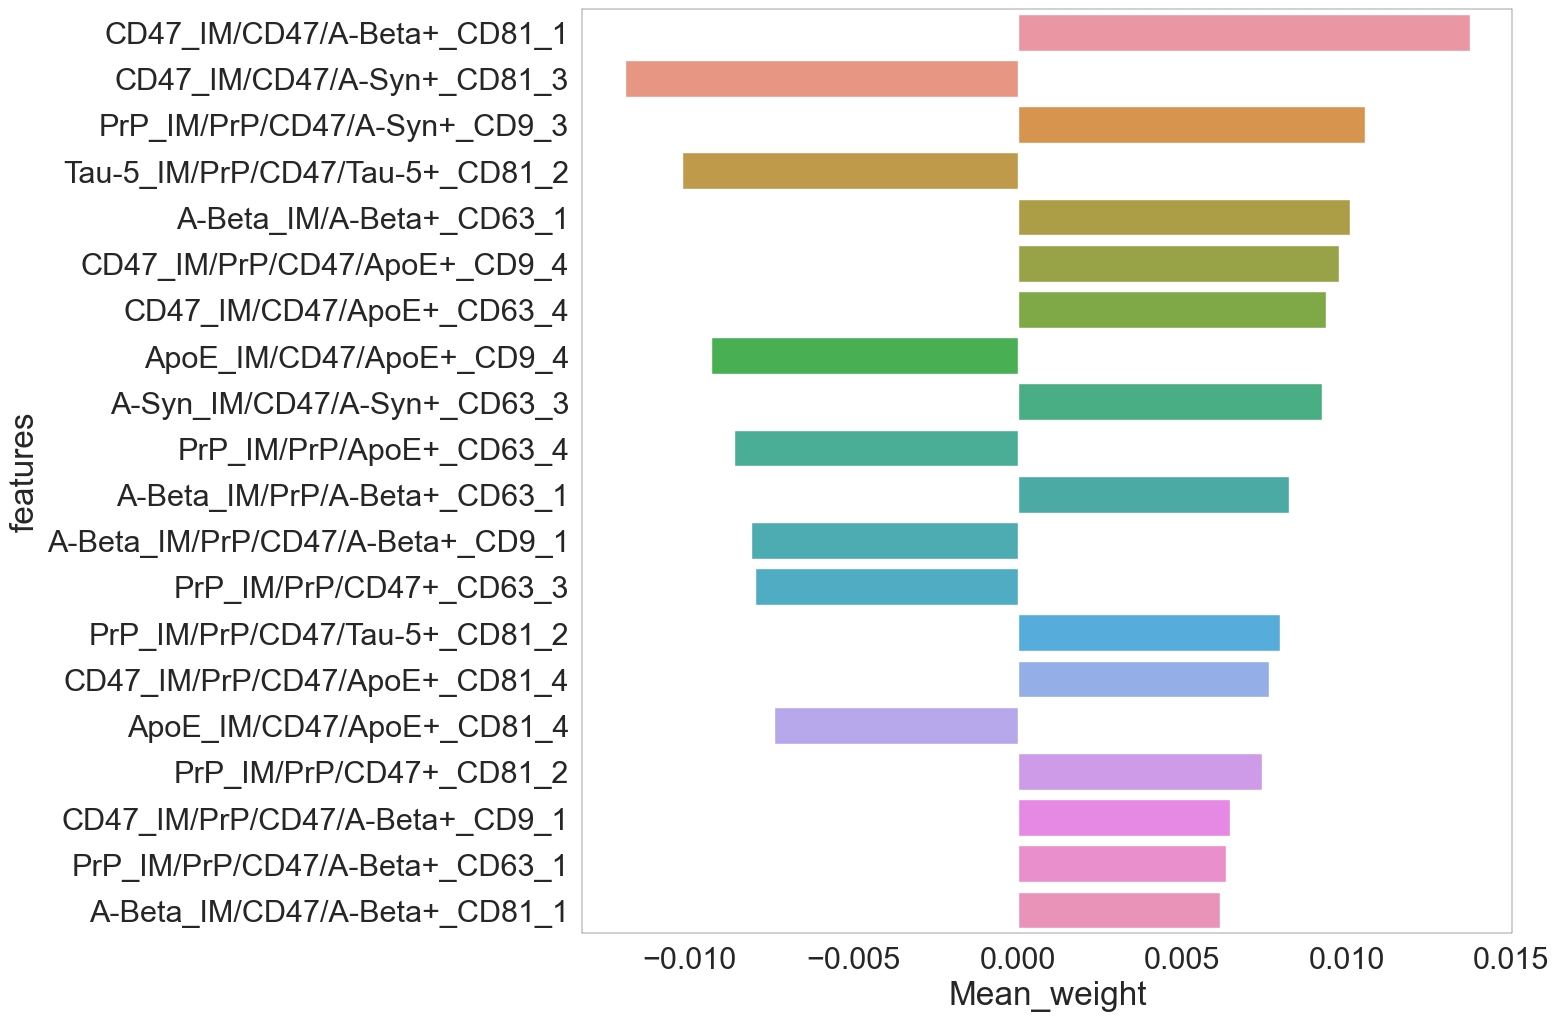

In [893]:
wt_df = pd.DataFrame({"features": col_to_use, "Mean_weight":wt.mean(0)})
wt_df["Abs_mw"] = np.abs(wt_df["Mean_weight"].values)
wt_df = wt_df.sort_values("Abs_mw", ascending=False)

fig, ax = plt.subplots(figsize=(12,12))
sns.barplot(data=wt_df.iloc[:20], y="features", x="Mean_weight",ax=ax)
#plt.tick_params(axis="x",rotation=90)


In [800]:
import many
sp = many.stats.mat_mwu(pd.DataFrame(X),pd.DataFrame(y), melt=True, effect="rank_biserial").reset_index()

ModuleNotFoundError: No module named 'many'

In [238]:
mean_express = coloc_df.groupby(["cluster", "Diagnosis", "samples", "spot"])["IM"].mean()#.unstack().fillna(0)


df_plot = coloc_df.reset_index().groupby(["cluster", "Diagnosis", "samples", "spot"])[cols].mean().reset_index().melt(["cluster", "Diagnosis", "samples", "spot"]).fillna(0)
y = "Mean expression"
df_plot.rename({"value":y}, inplace=True, axis=1)
df_plot[y].replace([np.inf, -np.inf], 0, inplace=True)
df_plot[y] = df_plot[y].astype(float)



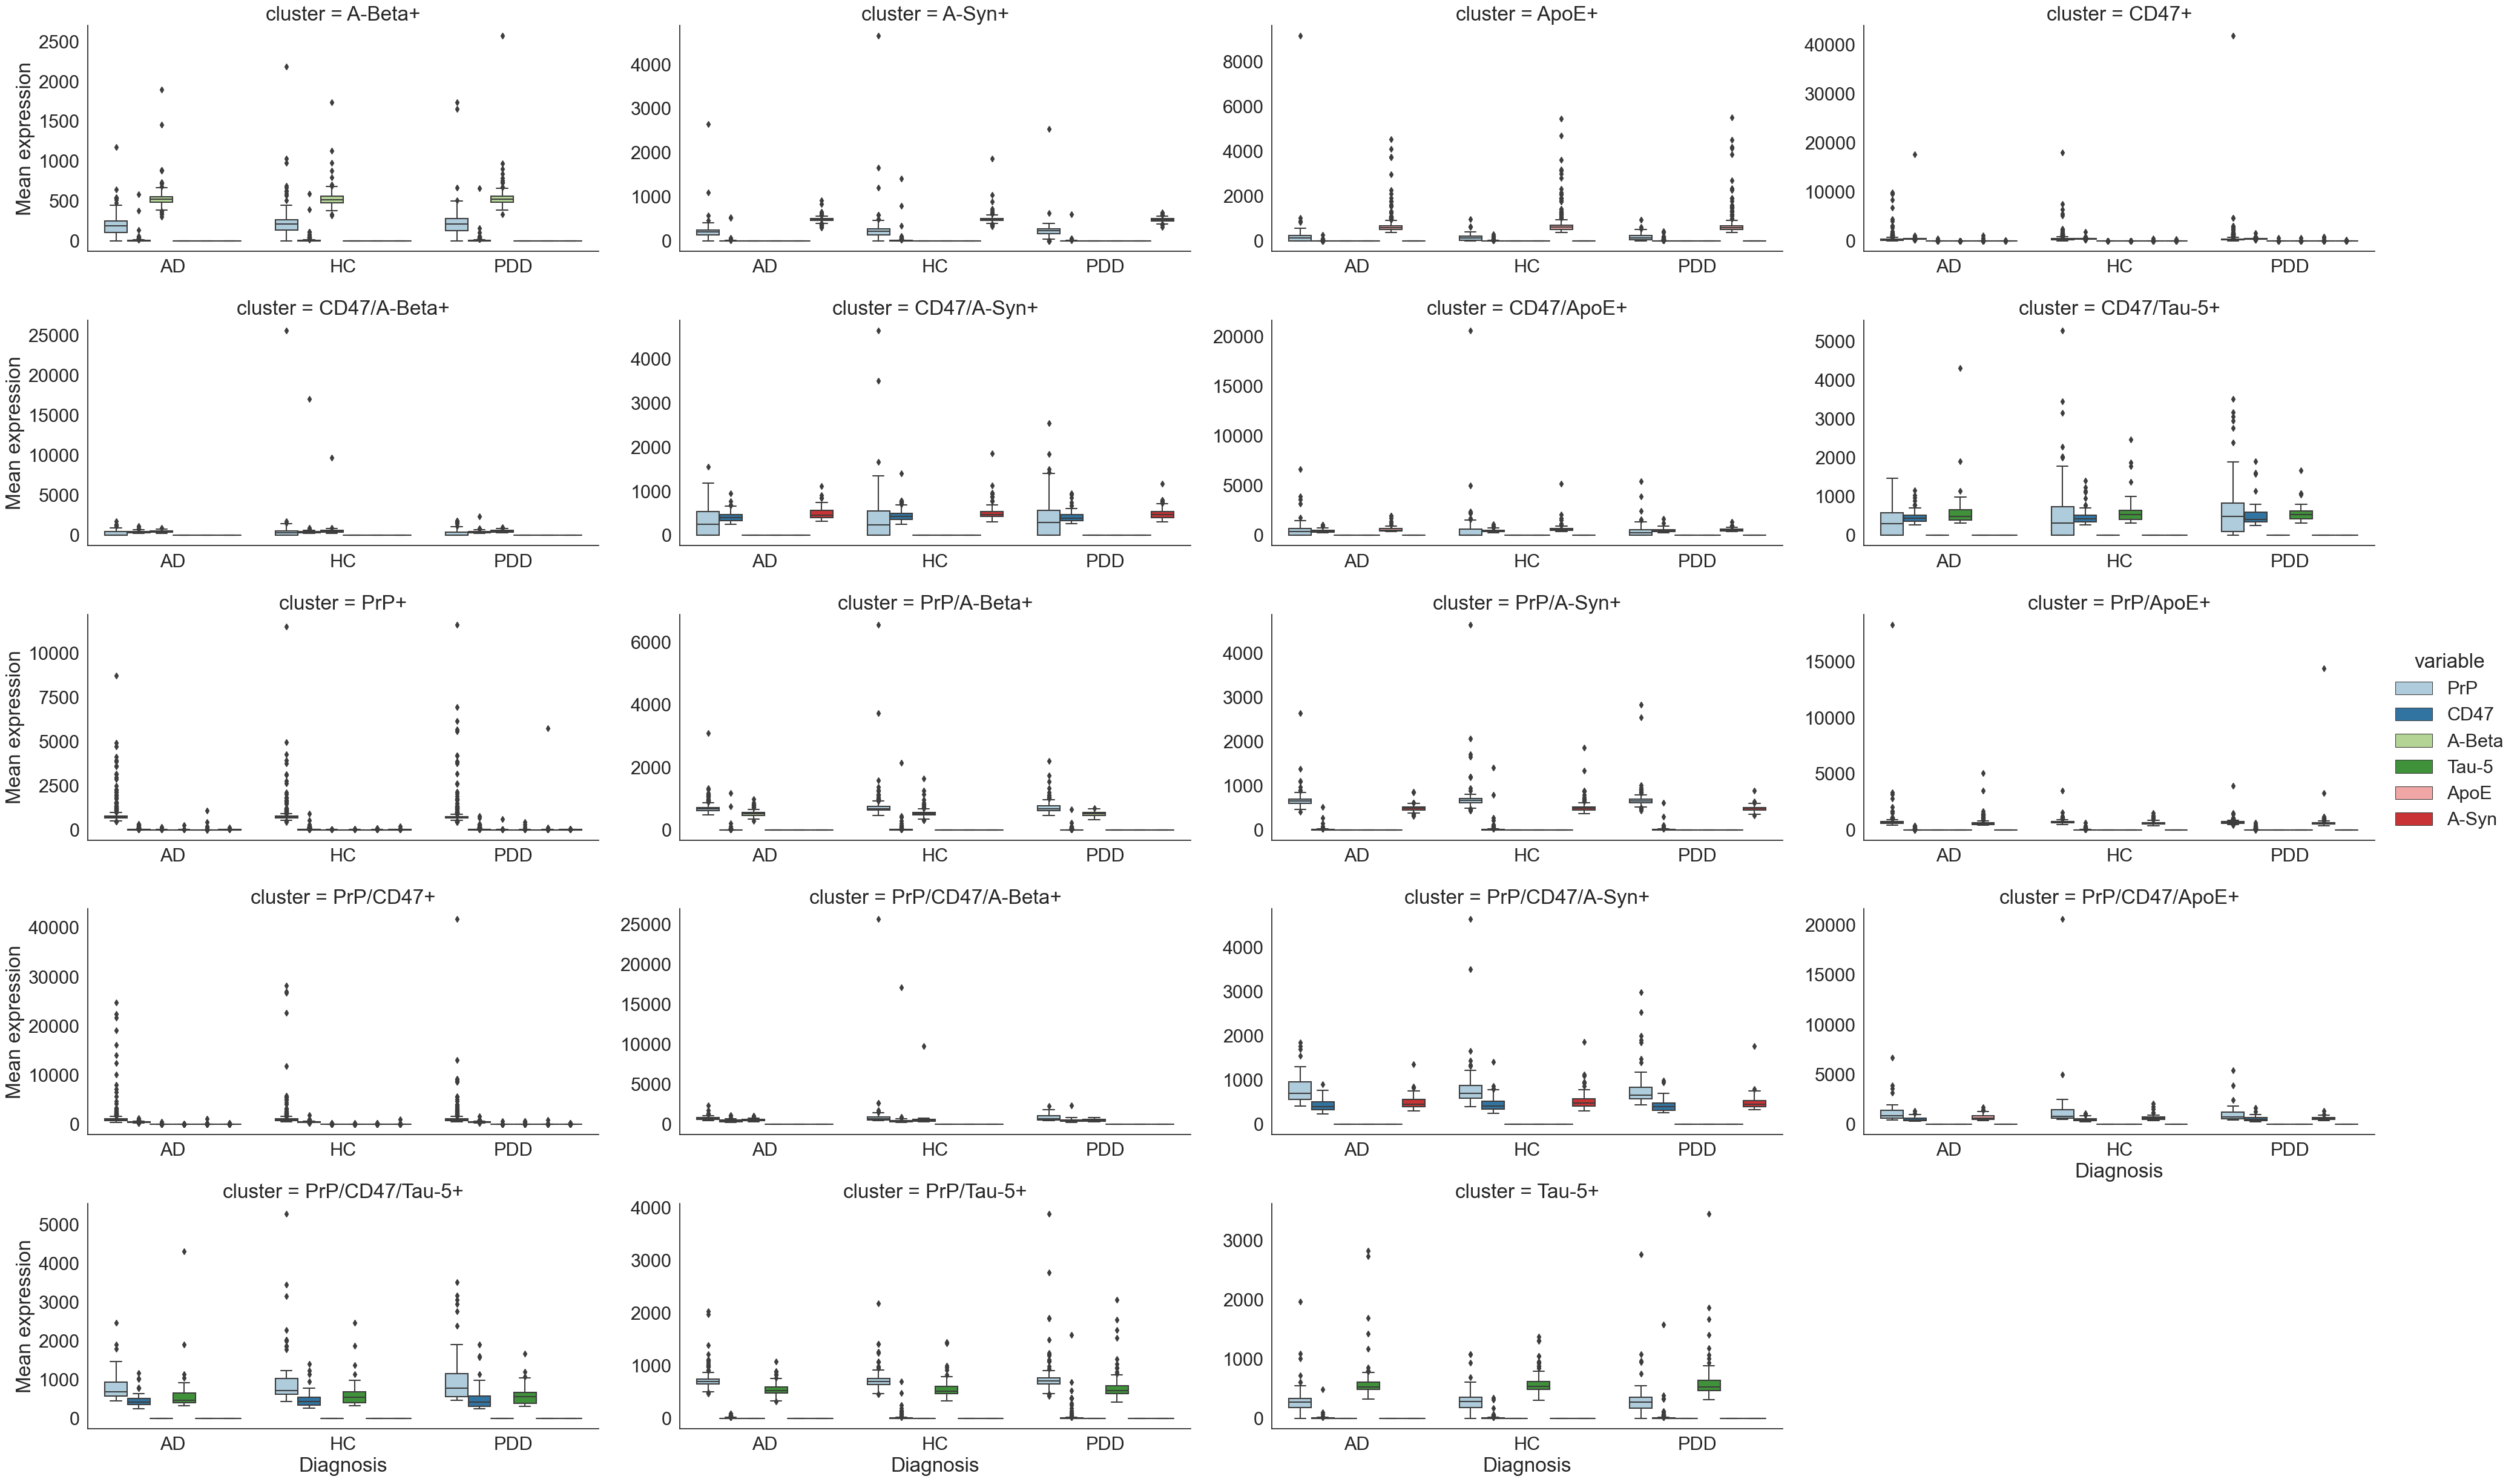

In [239]:
g = sns.catplot(
    data=df_plot, #.loc[df_plt.variable!='PrP', :],
    kind="box",
    x="Diagnosis", y=y, hue="variable",col="cluster",
    col_wrap=4,sharex=False, sharey=False,
    palette="Paired", 
    #alpha=.6, 
    height=5, aspect=2,
)
# g.despine(left=True)
# pairs = [(("MCI", "Tau-5"),( i, "Tau-5")) for i in df_plt.Diagnosis.unique() if i != "MCI"]
# pairs =[]
# for name,ax in g.axes_dict.items():
#     if name =="CD47/PrP/Tau-5+":
#         pairs = [(("MCI", "Tau-5"),( i, "Tau-5")) for i in df_plt.Diagnosis.unique() if i != "MCI"]
#     # elif name =="A-Beta/CD47/PrP+":
#     #     pairs = [(("HC", "Tau-5"),( i, "Tau-5")) for i in df_plt.Diagnosis.unique() if i != "AD"]
#     if len(pairs)>0:
#         print(name)
# # subset the table otherwise the stats were calculated on the whole dataset
#         annot = Annotator(ax, pairs, data=df_plot, x=x, y=y, hue="variable") 
#         annot.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
#         annot.apply_test().annotate()
#         pairs=[]

In [240]:
coloc_df.marker.unique()

array(['CD63', 'CD81', 'CD9', 'MIgG'], dtype=object)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

AD vs. HC: Mann-Whitney-Wilcoxon test two-sided, P_val:4.023e-01 U_stat=2.752e+03
HC vs. PDD: Mann-Whitney-Wilcoxon test two-sided, P_val:3.293e-01 U_stat=2.275e+03
AD vs. PDD: Mann-Whitney-Wilcoxon test two-sided, P_val:9.358e-01 U_stat=2.828e+03
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

AD vs. HC: Mann-Whitney-Wilcoxon test two-sided, P_val:1.091e-02 U_stat=3.575e+04
HC vs. PDD: Mann-Whitney-Wilcoxon test two-sided, P_val:6.466e-01 U_stat=4.050e+04
AD vs. PDD: Mann-Whitney-Wilcoxon test two-sided, P_val:4.246e-02 U_stat=3.636e+04
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < 

Text(0.5, 0.98, 'CD63')

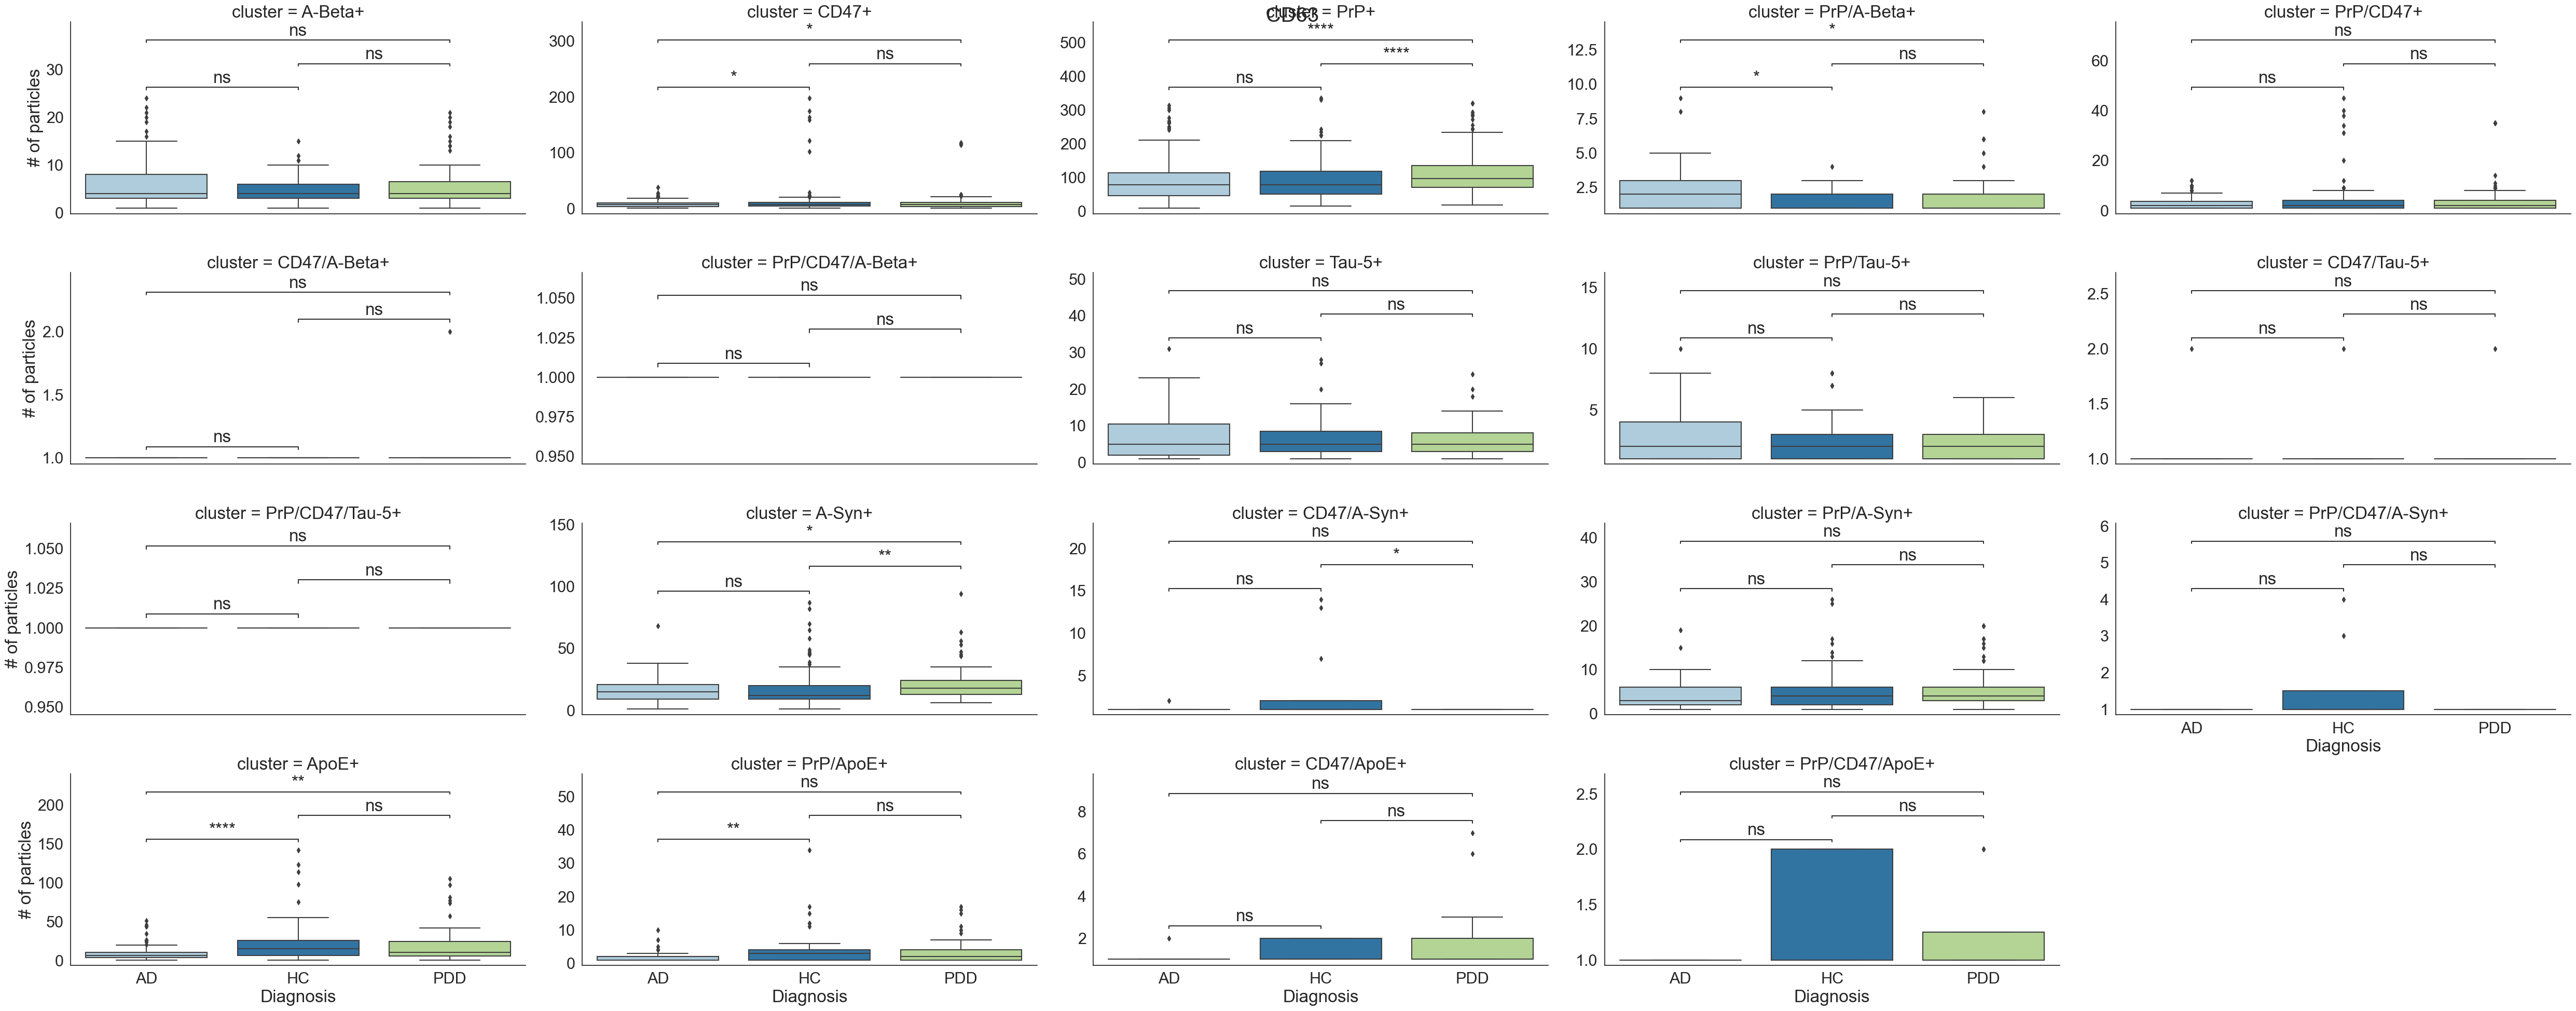

In [241]:
#df_plt = coloc_df.groupby(["cluster", "Diagnosis", "samples", "spot"]).size()#.unstack().fillna(0)
groupby_cols = ['Diagnosis', "panel", 'samples', "cluster", "spot"]
mark = "CD63"
df_plt = coloc_df[coloc_df.marker==mark].groupby(groupby_cols).size().reset_index()
df_plt = df_plt.melt(groupby_cols)
df_plt.head(3)
x="Diagnosis"
sns.set(font_scale=2, style="white")
y="# of particles"
df_plt.rename({"value":y}, axis=1, inplace=True)
# g = sns.catplot(
#     data=df_plt.loc[df_plt.variable=='PrP', :], 
#     kind="bar",
#     x=x, y=y, hue="variable",col="marker",#col_wrap=2,
#     palette="Paired", alpha=.6, height=5, aspect=1.5,
#     #sharex=True,
#     sharey=True,
    
# )
g = sns.catplot(
    data=df_plt, 
    kind="box",
    x=x, y=y,col="cluster",col_wrap=5,
    palette="Paired", #alpha=.6, 
    height=5, aspect=2,
    #sharex=True,
    sharey=False,
    
)
pairs = [("AD", "HC"), ("HC", "PDD"), ("AD", "PDD")]

for name,ax in g.axes_dict.items():
# if True:
#         ax = g.ax
# # subset the table otherwise the stats were calculated on the whole dataset
        tmp = df_plt[df_plt.cluster==name]
        annot = Annotator(ax, pairs, data=tmp, x=x, y=y) 
        annot.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
        annot.apply_test().annotate()
        
plt.suptitle(mark)

In [247]:
groupby_cols = ['Diagnosis', "panel", 'samples', "cluster", "spot", "marker"]
mark = "CD63"
df_plt = coloc_df[coloc_df.marker==mark].groupby(groupby_cols).size().reset_index(level=3).rename({0:"#percluster"}, axis=1)
df_plt = df_plt.join(coloc_df[coloc_df.marker==mark].groupby(['Diagnosis', "panel", 'samples', "spot"]).size().to_frame().rename({0:"#perspot"},axis=1))

all_the_particle = True #False
if all_the_particle:
    df_plt = coloc_df[coloc_df!= "MIgG"].groupby(groupby_cols).size().reset_index(level=3).rename({0:"#percluster"}, axis=1)
    df_plt = df_plt.join(coloc_df.groupby(['Diagnosis', "panel", 'samples', "spot"]).size().to_frame().rename({0:"#perspot"},axis=1))


df_plt["prop"] = df_plt["#percluster"]/df_plt["#perspot"]
df_plt = df_plt.reset_index()

In [249]:
df_plt

Diagnosis  panel samples   spot marker       cluster  #percluster   
0            AD      1      31  Spot1   CD81       A-Beta+           58  \
1            AD      1      31  Spot1   CD81         CD47+           38   
2            AD      1      31  Spot1   CD81  CD47/A-Beta+            4   
3            AD      1      31  Spot1   CD81          PrP+          447   
4            AD      1      31  Spot1   CD81   PrP/A-Beta+           10   
...         ...    ...     ...    ...    ...           ...          ...   
14009       PDD      4      90  Spot9    CD9         CD47+           37   
14010       PDD      4      90  Spot9    CD9    CD47/ApoE+            1   
14011       PDD      4      90  Spot9    CD9          PrP+          830   
14012       PDD      4      90  Spot9    CD9     PrP/ApoE+           22   
14013       PDD      4      90  Spot9    CD9     PrP/CD47+           14   

       #perspot      prop  
0           570  0.101754  
1           570  0.066667  
2           570  0.007018  
3           570  0.784211  
4           570  0.017544  
...         ...       ...  
14009       970  0.038144  
14010       970  0.001031  
14011       970  0.855670  
14012       970  0.022680  
14013       970  0.014433  

[14014 rows x 9 columns]

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

AD vs. HC: Mann-Whitney-Wilcoxon test two-sided, P_val:1.841e-02 U_stat=3.015e+04
HC vs. PDD: Mann-Whitney-Wilcoxon test two-sided, P_val:1.561e-01 U_stat=2.680e+04
AD vs. PDD: Mann-Whitney-Wilcoxon test two-sided, P_val:1.176e-04 U_stat=3.230e+04
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

AD vs. HC: Mann-Whitney-Wilcoxon test two-sided, P_val:6.237e-02 U_stat=4.354e+05
HC vs. PDD: Mann-Whitney-Wilcoxon test two-sided, P_val:8.287e-06 U_stat=4.826e+05
AD vs. PDD: Mann-Whitney-Wilcoxon test two-sided, P_val:6.407e-03 U_stat=4.617e+05
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < 

Text(0.5, 0.98, 'CD63')

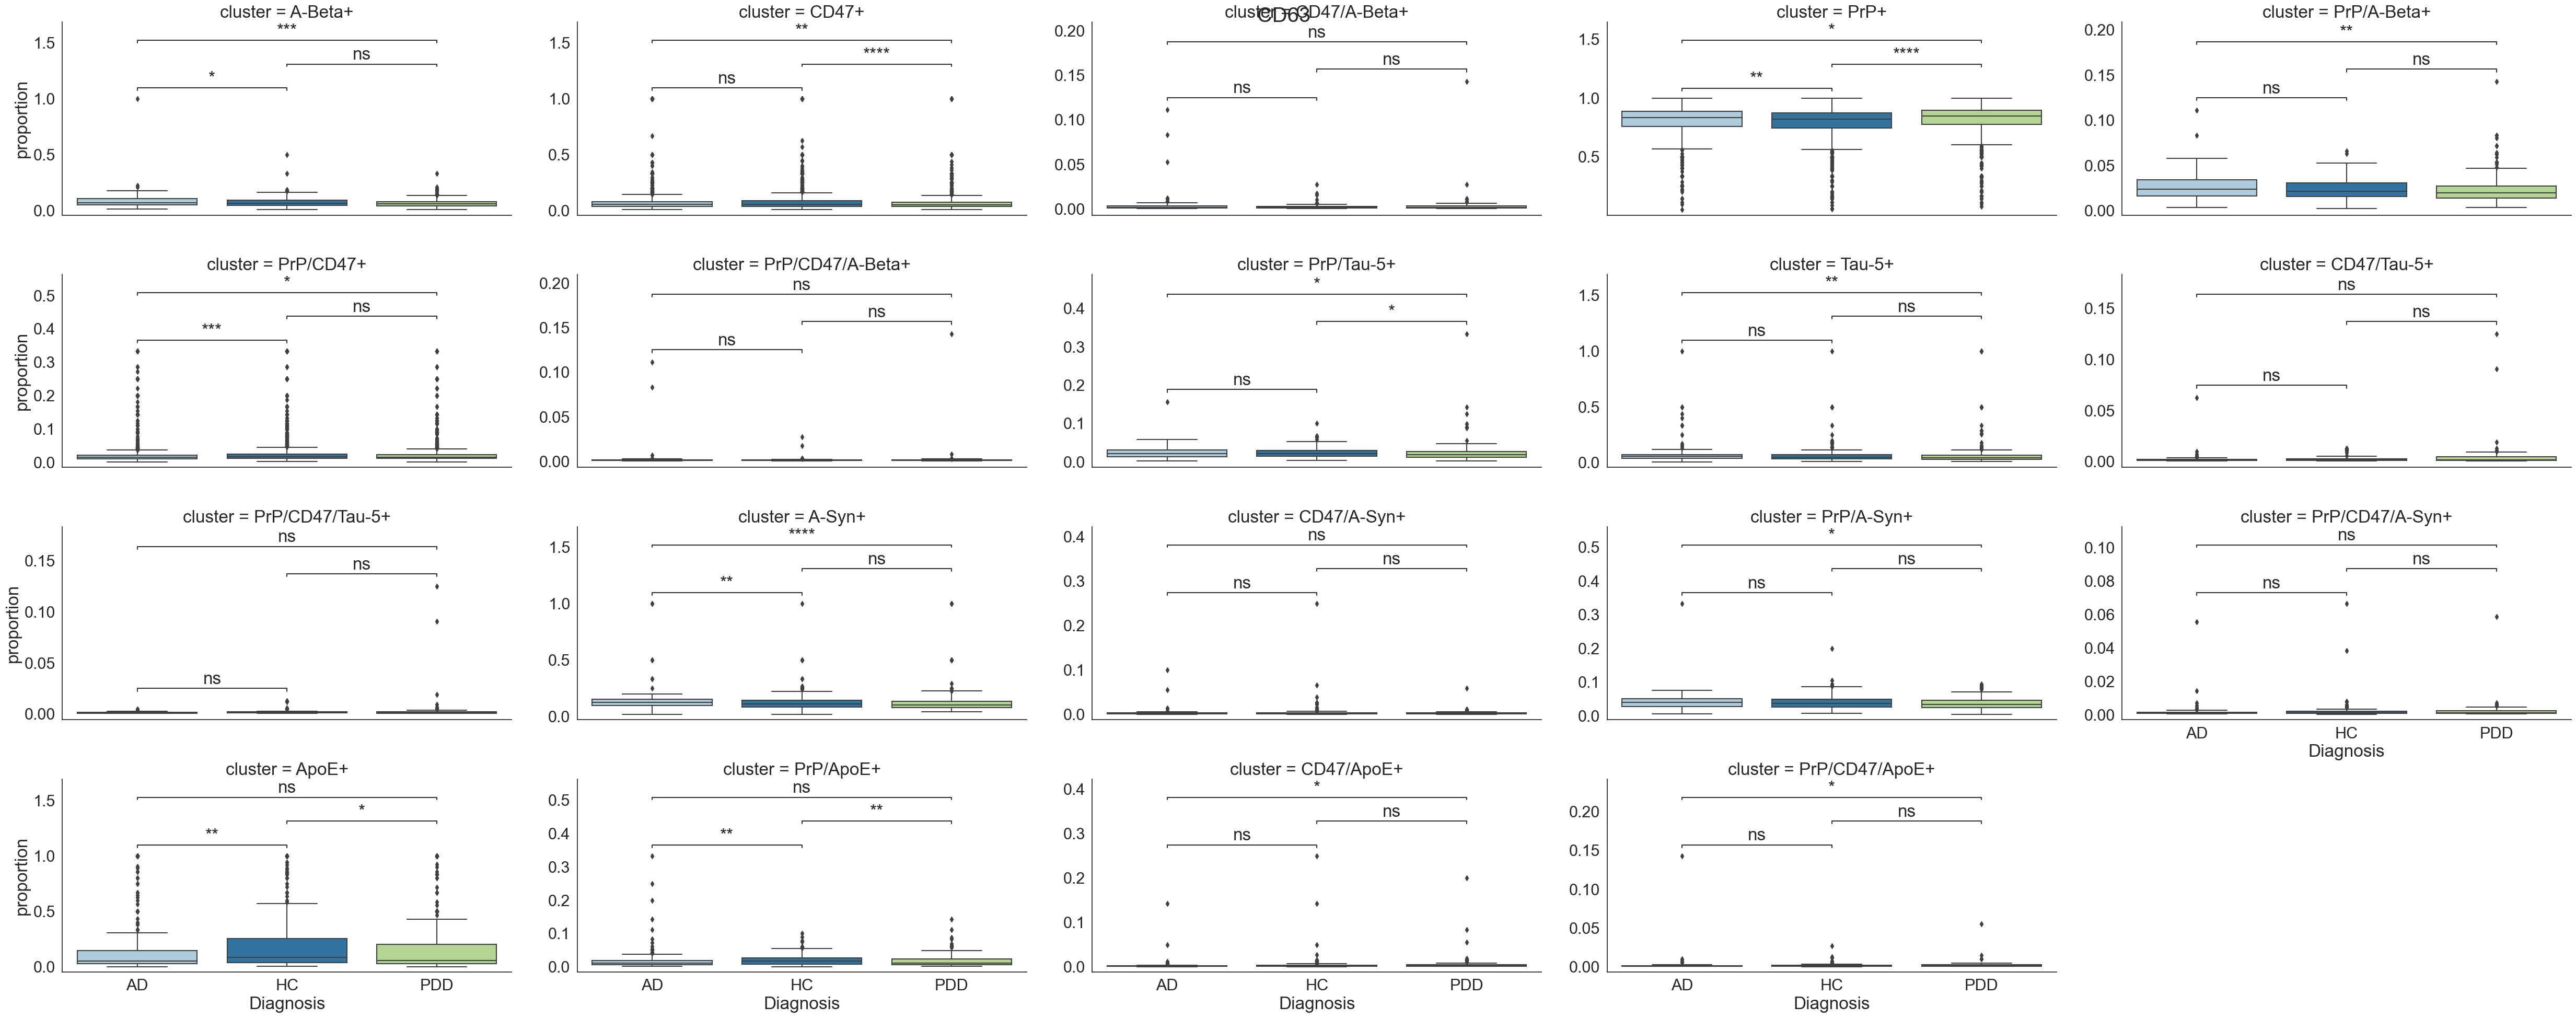

In [221]:
df_plt =df_plt[groupby_cols + ["prop"]].melt(groupby_cols)
df_plt.head(3)
x="Diagnosis"
sns.set(font_scale=2, style="white")
y="proportion"
df_plt.rename({"value":y}, axis=1, inplace=True)
# g = sns.catplot(
#     data=df_plt.loc[df_plt.variable=='PrP', :], 
#     kind="bar",
#     x=x, y=y, hue="variable",col="marker",#col_wrap=2,
#     palette="Paired", alpha=.6, height=5, aspect=1.5,
#     #sharex=True,
#     sharey=True,
    
# )
g = sns.catplot(
    data=df_plt, 
    kind="box",
    x=x, y=y,col="cluster",col_wrap=5,
    palette="Paired", #alpha=.6, 
    height=5, aspect=2,
    #sharex=True,
    sharey=False,
    
)
pairs = [("AD", "HC"), ("HC", "PDD"), ("AD", "PDD")]

for name,ax in g.axes_dict.items():
# if True:
#         ax = g.ax
# # subset the table otherwise the stats were calculated on the whole dataset
        tmp = df_plt[df_plt.cluster==name]

        annot = Annotator(ax, pairs, data=tmp, x=x, y=y) 
        annot.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
        annot.apply_test().annotate()
        
plt.suptitle(mark)